### w261 Team13 - Final Project - Summer 2021
###### Ryan Orton, Jason Papale, John Slater

#### Section 1 - Question Formulation and Problem Defintion

The analysis attempts to determine if weather and flight data can be used to predict flight delays. Flight delays are estimated to cost carriers $33b in 2019. Delays impact operations, safety and customer experience in addition to costing government agencies an undisclosed amount. If flight and weather data can be used to predict delays, operations can be better managed to minize financial and customer experience costs. To achieve these benefits, it is important to refine the question to include materiality of flight delays: '... if weather and flight data can be used to predict **material** flight delays.' For this exercise the threshold of 15 minutes delay has been selected for two reasons: i) availability - 15 minute delay is available data field and ii) practicality - 15 minutes seems a reasonable estimation of material delays.

The Bureau of Transportation Statistics (https://www.transtats.bts.gov) provides on-time performance data for most large carriers. The information gathered includes on-time performance, delays, cancellations, flight distances, in addition to many other descriptive statistics. The un-cleansed flight dataset contains 63,493,682 records and 109 features, gathered from 2015 - 2019. Dropping duplicate records bring this down to 31,746,841 records.

Weather data is provided by the National Oceanic and Atmospheric Administration (https://repository.library.noaa.gov). The data is gathered through Integrated Surface Data system, and it contains static and custom fields indicating weather conditions and the time and location the measurement was taken. The un-cleansed dataset contains 630,904,436 records and 177 features, gathered from 2015-2019. The most significant limitation of this dataset is lack of standardized (published) data definitions. In our analysis of the 177 features available in the weather dataset, fewer than 10 appeared to be used consistently, and have published definitions. 

In addition, an airport station dataset is provided from the US Department of Transportation (US Department of Transportation) to match weather station locations to airport locations. This file is 18,097 records by 10 features.

Refining the initial question to both make sense for materiality and align with data availability turns this into a classification problem. To test the predictive power of the features we will use logistic regression, a random forest classifier, and gradient boosted tree algorithms. The use case of the model would ultimately determine what measure should be optimized. From the perspective of customer expectations management, it may be preferable to optimize the model such that preference is given towards minimizing false positives over false negatives. In this instance, predictions of flight delays would be more rare, and the risk of a customer changing his or her plans based on the understanding that the flight will be delayed (only for this not to be the case) are minimized.  Conversely, from the perspective of operations management, who may be able to implement lower-cost measures to mitigate the effects of a future flight delay if sufficient advance notice is given, may perfer a model which is optimized to give preference towards minimizing false negatives over false positives. We will consider customary classification evaluation metrics - false negative, false positive, true negative, true positive, accuracy, and F1.  Given the unbalanced nature of the data, we will also consider the area under precision-recall curve; however, we will use area under the ROC curve as the primary evaluation metric. 

Baselines would be best set with further industry and financial knowledge. These baselines would indicate the level of accuracy required for the model to provide a positive cost - benefit analysis - ie. is this a good model - for this specific application. Our baselines will come from reference papers, the research paper *A Data Mining Approach to Flight Arrival Delay Prediction for American Airlines* (Ref 1) has two strategies which achieve area under ROC curve results of 0.71 and 0.90, while *Characterization and Prediction of Air Traffic Delays* (Ref 2) yields random forest test error results in the range of ~20%.

This narrow approach does not consider many other hyper parameters which could have a significant impact on results, most significantly: changes in classification threshold, and changes in weather forecast time horizon. 

Ref 1: **A Data Mining Approach to Flight Arrival Delay Prediction for American Airlines**, Navoneel Chakrabarty, Computer Science and Engineering Jalpaiguri Government Engineering College. https://journalofbigdata.springeropen.com/articles/10.1186/s40537-020-00380-z

Ref 2: **Characterization and Prediction of Air Traffic Delays**, Juan Jose Rebollo de la Bandera, Massachusetts Institute of Technology. https://dspace.mit.edu/bitstream/handle/1721.1/111158/Balakrishnan_Characterization%20and.pdf;jsessionid=F38749A259705CED952B4F1DD31250AA?sequence=1

###### Prepare Environment

In [1]:
# Install libraries to environment 
!pip install scikit-learn -U

In [0]:
# Import Libraries
import pyspark
from pyspark.sql import functions as F, Row
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from distutils.version import LooseVersion
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, max, substring
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.util import MLUtils
from pyspark.sql.functions import col, row_number, when, lag, avg, isnan, count, create_map, lit
from pyspark.sql.window import Window
from pyspark.sql.types import FloatType
from pyspark.sql.types import IntegerType, StringType
from itertools import chain
from pytz import timezone

import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import os
import numpy as np

from math import sin, cos, sqrt, atan2, radians

plt.rcParams.update({'font.size': 12})

In [0]:
# Define conf 
spark.conf.set("spark.databricks.io.cache.enabled", "true")

# Define mount path
mount_path = "/mnt/mids-w261"

# Inspect the Mount's Final Project folder 
display(dbutils.fs.ls("/mnt/mids-w261/"))

# Data directory
DATA_PATH = "dbfs:/mnt/mids-w261/datasets_final_project/"

# Create file path
# dbutils.fs.mkdirs('dbfs:/mnt/w261/team22')
FILE_PATH = 'dbfs:/mnt/w261/team13/'
display(dbutils.fs.ls(DATA_PATH))

path name size dbfs:/mnt/mids-w261/HW5/ HW5/ 0 dbfs:/mnt/mids-w261/datasets_final_project/ datasets_final_project/ 0

path name size dbfs:/mnt/mids-w261/datasets_final_project/airlines/ airlines/ 0 dbfs:/mnt/mids-w261/datasets_final_project/airlines_data/ airlines_data/ 0 dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/ parquet_airlines_data/ 0 dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data_3m/ parquet_airlines_data_3m/ 0 dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data_6m/ parquet_airlines_data_6m/ 0 dbfs:/mnt/mids-w261/datasets_final_project/stations_data/ stations_data/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data/ weather_data/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data_6_hr/ weather_data_6_hr/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data_single/ weather_data_single/ 0

In [0]:
# Start spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [0]:
# Print spark session variable
spark

Out[5]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.1 
 Master 
 spark://10.0.128.21:7077 
 AppName 
 Databricks Shell

###### Define Helper Functions

In [0]:
# Helper function to count nulls and nans
from pyspark.sql.functions import isnan, when, count, col

def count_missings(spark_df,sort=False):
    """
    Counts number of nulls and nans in each column
    """
    df = spark_df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes if c_type not in ('timestamp')]).toPandas()

    if len(df) == 0:
        print("There are not any missing values!")
        return None

    if sort:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

    return df

In [0]:
# Helper function to print evaluation metrics
def print_results(predictions):
  """
  Calculates Confusion matrix and prints AUC for ROC and Precision
  """
  tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()
  tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()
  fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()
  fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()
  total = predictions.count()
  recall = float(tp)/(tp + fn)
  
  data = {'Actual: delay': [tp, fn], 'Actual: on-time': [fp, tn]}
  confusion_matrix = pd.DataFrame.from_dict(data, orient='index', 
                                          columns=['Prediction: delay', 'Prediction: on-time'])
  
  print("Test Area Under ROC: ", "{:.2f}".format(evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})))
  print("Test Area Under Precision-Recall Curve: ", "{:.2f}".format(evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderPR'})))

  print("True positive rate: {:.2%}".format(tp/(tp + fn)))
  print("True negative rate: {:.2%}".format(tn/(tn + fp)))
  print("False positive rate: {:.2%}".format(fp/(fp + tn)))
  print("False negative rate: {:.2%}".format(fn/(tp + fn)))
  print("Recall: {:.2%}".format(recall))
  
  print("########### Confusion Matrix ###########")
  print(confusion_matrix)

In [0]:
# Helper function for determining distance between two points on Earth
def haversine(lat1, lon1, lat2, lon2):
  # approximate radius of earth in km
  R = 6373.0

  lat1 = radians(lat1)
  lon1 = radians(lon1)
  lat2 = radians(lat2)
  lon2 = radians(lon2)

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  distance = R * c
  return distance

haversine_udf = udf(haversine, FloatType())

In [0]:
# Helper function to plot confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\nAccuracy={:0.4f}; Misclassification Rate={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [0]:
def ExtractFeatureImportance(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

#### Section 2 - Data Import and Initial Exploratory Data Analysis

This analysis focuses on two categories of exploratory data analysis: i) feature variables and ii) target variable. Of note, the EDA contained within this section focuses primarily on flight data.  A more in-depth assessment of both the weather data and features which required a greater degree of feature engineering (some of which were used in joining the weather data to the flight data) is shown after these components are built out.

Five insights stand out as most impactful to the algorithm and analysis, four regarding features and one concerning the target variable:
- **Distribution of Departure Times by Proportion of Flights Delayed** chart below shows a skew right trend indicating a possible relationship between the time of day a flight departs, and the likelihood of being delayed. The implication would be that the later in the day a flight is departs, the more likely it is to be delayed. This will be explored further in the algorithm exploration. 
- **Histogram of Flight Delays (By Minutes)** this has a skew right, showing that most flight delays are under 20 minutes. This indicates changing the classification threshold (with respect to the magnitude of the delay, not the probability of the delay) could have a significant impact on algorithm performance. As noted above, changing the classification threshold is not covered in the analysis.
- **Distribution of Key Features** indicates for these features under consideration, which have extreme outliers and will inform our approach to data transformation for those features. 
- **Presence of Null Values in Flight Data** this bar chart shows that nearly half of the fields in the flight data have a very high number of nulls, indicating they will not be useful as potential features in our models.
- **Flights by Presence of >=15 Minute Delay** indicates an unbalanced target variable - most flights are not delayed - this will be accounted for during algorithm exploration.

###### Loading Data

In [0]:
# Load weather data
df_weather = spark.read.parquet(f"{mount_path}/datasets_final_project/weather_data/*")

In [0]:
# Load flight data
df_flights = spark.read.parquet("/mnt/mids-w261/datasets_final_project/parquet_airlines_data/*")

In [0]:
# Load station data
df_stations = spark.read.parquet("/mnt/mids-w261/datasets_final_project/stations_data/*")

In [0]:
# Load Airport to Lat and Long Mapping

# File location and type
file_location = "/FileStore/tables/airport_codes_csv.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
airport_mapping_df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

###### Initial Assessment of Data

In [0]:
df_weather.count()

Out[15]: 630904436

In [0]:
display(df_weather)

STATION DATE SOURCE LATITUDE LONGITUDE ELEVATION NAME REPORT_TYPE CALL_SIGN QUALITY_CONTROL WND CIG VIS TMP DEW SLP AW1 GA1 GA2 GA3 GA4 GE1 GF1 KA1 KA2 MA1 MD1 MW1 MW2 OC1 OD1 OD2 REM EQD AW2 AX4 GD1 AW5 GN1 AJ1 AW3 MK1 KA4 GG3 AN1 RH1 AU5 HL1 OB1 AT8 AW7 AZ1 CH1 RH3 GK1 IB1 AX1 CT1 AK1 CN2 OE1 MW5 AO1 KA3 AA3 CR1 CF2 KB2 GM1 AT5 AY2 MW6 MG1 AH6 AU2 GD2 AW4 MF1 AA1 AH2 AH3 OE3 AT6 AL2 AL3 AX5 IB2 AI3 CV3 WA1 GH1 KF1 CU2 CT3 SA1 AU1 KD2 AI5 GO1 GD3 CG3 AI1 AL1 AW6 MW4 AX6 CV1 ME1 KC2 CN1 UA1 GD5 UG2 AT3 AT4 GJ1 MV1 GA5 CT2 CG2 ED1 AE1 CO1 KE1 KB1 AI4 MW3 KG2 AA2 AX2 AY1 RH2 OE2 CU3 MH1 AM1 AU4 GA6 KG1 AU3 AT7 KD1 GL1 IA1 GG2 OD3 UG1 CB1 AI6 CI1 CV2 AZ2 AD1 AH1 WD1 AA4 KC1 IA2 CF3 AI2 AT1 GD4 AX3 AH4 KB3 CU1 CN4 AT2 CG1 CF1 GG1 MV2 CW1 GG4 AB1 AH5 CN3 7650099999 2016-01-01T00:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-12 99999 V020 190,1,N,0015,1 99999,9,9,N 007000,1,9,9 +0101,1 +0090,1 10255,1 99,9,+02250,1,99,9 9,AGL ,+99999,+99999 08,99,1,99,9,99,9,02250,1,99,9,99,9 99999,9,10216,1 8,1,004,1,+999,9 61,1 3,99,0026,1,999 SYN09807650 04857 81903 10101 20090 30216 40255 58004 69901 761// 333 4/000 69907 90710 91105 555 69905= 9999,1,9,999999,9,9 03,0000,2,1 06,0000,2,1 7650099999 2016-01-01T00:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-15 99999 V020 190,1,N,0015,1 22000,1,9,N 009000,1,9,9 +0100,1 +0090,1 99999,9 61,1 00,99,1,99,9,99,9,99999,9,99,9,99,9 10250,1,99999,9 MET057METAR LFML 010000Z AUTO 19003KT 9000 -RA NSC 10/09 Q1025= 7650099999 2016-01-01T00:30:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-15 99999 V020 250,1,N,0010,1 99999,9,9,N 008000,1,9,9 +9999,9 +9999,9 99999,9 10250,1,99999,9 MET056METAR LFML 010030Z AUTO 25002KT 8000 ///TCU 10/09 Q1025= Q019 2ATOD 7650099999 2016-01-01T01:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-12 99999 V020 999,9,C,0000,1 99999,9,9,N 004900,1,9,9 +0099,1 +0094,1 10251,1 99,9,+02250,1,99,9 9,AGL ,+99999,+99999 08,99,1,99,9,99,9,02250,1,99,9,99,9 99999,9,10212,1 8,1,006,1,+999,9 10,1 3,99,0015,1,999 SYN07607650 24849 80000 10099 20094 30212 40251 58006 710// 333 69925 90710 91103= 01,0002,3,1 7650099999 2016-01-01T01:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-15 99999 V020 999,9,C,0000,1 22000,1,9,N 007000,1,9,9 +0100,1 +0090,1 99999,9 00,99,1,99,9,99,9,99999,9,99,9,99,9 10250,1,99999,9 MET053METAR LFML 010100Z AUTO 00000KT 7000 NSC 10/09 Q1025= 7650099999 2016-01-01T01:30:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-15 99999 V020 999,9,C,0000,1 22000,1,9,N 009000,1,9,9 +0100,1 +0090,1 99999,9 00,99,1,99,9,99,9,99999,9,99,9,99,9 10250,1,99999,9 MET053METAR LFML 010130Z AUTO 00000KT 9000 NSC 10/09 Q1025= 7650099999 2016-01-01T02:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-12 99999 V020 999,9,C,0000,1 99999,9,9,N 011000,1,9,9 +0100,1 +0088,1 10254,1 99,9,+01750,1,99,9 9,AGL ,+99999,+99999 08,99,1,99,9,99,9,01750,1,99,9,99,9 99999,9,10215,1 5,1,005,1,+999,9 00,1 3,99,0010,1,999 SYN07607650 24761 80000 10100 20088 30215 40254 55005 700// 333 60005 90710 91102= 01,0000,9,1 7650099999 2016-01-01T02:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-15 99999 V020 999,9,C,0000,1 99999,9,9,Y 999999,9,9,9 +0100,1 +0090,1 99999,9 10250,1,99999,9 MET050METAR LFML 010200Z AUTO 00000KT CAVOK 10/09 Q1025= 7650099999 2016-01-01T02:30:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-15 99999 V020 320,1,N,0015,1 22000,1,9,N 008000,1,9,9 +0100,1 +0090,1 99999,9 00,99,1,99,9,99,9,99999,9,99,9,99,9 10250,1,99999,9 MET053METAR LFML 010230Z AUTO 32003KT 8000 NSC 10/09 Q1025= 7650099999 2016-01-01T03:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-12 99999 V020 040,1,N,0010,1 01500,1,9,N 006000,1,9,9 +0099,1 +0093,1 10253,1 07,1,+01500,1,06,1 9,AGL ,+99999,+99999 07,99,1,07,1,99,9,01500,1,99,9,99,9 99999,9,10214,1 6,1,002,1,+999,9 3,99,0021,1,999 SYN09207650 22756 70402 10099 20093 30214 40253 56002 875// 333 69927 87650 90710 91104 555 60005= 03,0002,3,1 7650099999 2016-01-01T03:00:00.000+0000 4 43.

In [0]:
# Count records
df_flights.count()

Out[32]: 63493682

In [0]:
# Flights drop duplicates
df_flights = df_flights.dropDuplicates()
df_flights.count()

Out[20]: 31746841

In [0]:
# Display flights
display(df_flights)

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED CANCELLATION_CODE DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY FIRST_DEP_TIME TOTAL_ADD_GTIME LONGEST_ADD_GTIME DIV_AIRPORT_LANDINGS DIV_REACHED_DEST DIV_ACTUAL_ELAPSED_TIME DIV_ARR_DELAY DIV_DISTANCE DIV1_AIRPORT DIV1_AIRPORT_ID DIV1_AIRPORT_SEQ_ID DIV1_WHEELS_ON DIV1_TOTAL_GTIME DIV1_LONGEST_GTIME DIV1_WHEELS_OFF DIV1_TAIL_NUM DIV2_AIRPORT DIV2_AIRPORT_ID DIV2_AIRPORT_SEQ_ID DIV2_WHEELS_ON DIV2_TOTAL_GTIME DIV2_LONGEST_GTIME DIV2_WHEELS_OFF DIV2_TAIL_NUM DIV3_AIRPORT DIV3_AIRPORT_ID DIV3_AIRPORT_SEQ_ID DIV3_WHEELS_ON DIV3_TOTAL_GTIME DIV3_LONGEST_GTIME DIV3_WHEELS_OFF DIV3_TAIL_NUM DIV4_AIRPORT DIV4_AIRPORT_ID DIV4_AIRPORT_SEQ_ID DIV4_WHEELS_ON DIV4_TOTAL_GTIME DIV4_LONGEST_GTIME DIV4_WHEELS_OFF DIV4_TAIL_NUM DIV5_AIRPORT DIV5_AIRPORT_ID DIV5_AIRPORT_SEQ_ID DIV5_WHEELS_ON DIV5_TOTAL_GTIME DIV5_LONGEST_GTIME DIV5_WHEELS_OFF DIV5_TAIL_NUM seq_sk 2017 2 6 16 5 2017-06-16 B6 20409 B6 N203JB 1225 13541 1354102 33541 MVY Martha's Vineyard, MA MA 25 Massachusetts 13 10721 1072102 30721 BOS Boston, MA MA 25 Massachusetts 13 1436 1527 51 51 1 3 1400-1459 5 1532 1600 5 1519 1605 46 46 1 3 1500-1559 0 null 0 43 38 28 1 70 1 0 0 14 0 32 null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 1 2018 3 8 30 4 2018-08-30 DL 19790 DL N852DN 2135 14747 1474703 30559 SEA Seattle, WA WA 53 Washington 93 12892 1289208 32575 LAX Los Angeles, CA CA 6 California 91 805 758 -7 0 0 -1 0800-0859 35 833 1045 12 1055 1057 2 2 0 0 1000-1059 0 null 0 170 179 132 1 954 4 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2 2017 2 6 17 6 2017-06-17 B6 20409 B6 N712JB 121 10721 1072102 30721 BOS Boston, MA MA 25 Massachusetts 13 14027 1402702 34027 PBI West Palm Beach/Palm Beach, FL FL 12 Florida 33 826 1003 97 97 1 6 0800-0859 18 1021 1307 2 1139 1309 90 90 1 6 1100-1159 0 null 0 193 186 166 1 1197 5 29 0 0 0 61 null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 3 2018 3 8 30 4 2018-08-30 DL 19790 DL N907DL 2225 14307 1430705 30721 PVD Providence, RI RI 44 Rhode Island 15 10397 1039707 30397 ATL Atlanta, GA GA 13 Georgia 34 1222 1212 -10 0 0 -1 1200-1259 14 1226 1429 15 1506 1444 -22 0 0 -2 1500-1559 0 null 0 164 152 123 1 903 4 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 4 2017 2 6 17 6 2017-06-17 B6 20409 B6 N648JB 620 14679 1467903 33570 SAN San Diego, CA CA 6 California 91 10721 1072102 30721 BOS Boston, MA MA 25 Massachusetts 13 1120 1115 -5 0 0 -1 1100-1159 18 1133 1930 7 2000 1937 -23 0 0 -2 2000-2059 0 null 0 340 322 297 1 2588 11 null null 

In [0]:
df_stations.count()

Out[17]: 5004169

In [0]:
display(df_stations)

usaf wban station_id lat lon neighbor_id neighbor_name neighbor_state neighbor_call neighbor_lat neighbor_lon distance_to_neighbor 690020 93218 69002093218 36.0 -121.233 69002093218 JOLON HUNTER LIGGETT MIL RES CA KHGT 36.0 -121.233 0.0 690020 93218 69002093218 36.0 -121.233 69007093217 FRITZSCHE AAF CA KOAR 36.683 -121.767 55.73024537916726 690020 93218 69002093218 36.0 -121.233 69014093101 EL TORO MCAS CA KNZJ 33.667 -117.733 255.49106220353934 690020 93218 69002093218 36.0 -121.233 70027127506 BARROW POINT BARROW AK KPBA 71.333 -156.65 2750.4353299559803 690020 93218 69002093218 36.0 -121.233 70045027512 LONELY AK LNI 70.917 -153.25 2676.3554370627153 690020 93218 69002093218 36.0 -121.233 70063027403 OLIKTOK POW 2 AK POLI 70.5 -149.883 2604.050248854232 690020 93218 69002093218 36.0 -121.233 70063526465 GALBRAITH LAKE AIRPORT AK PAGB 68.479 -149.49 2490.9756094472277 690020 93218 69002093218 36.0 -121.233 70063627405 PRUDHOE BAY AK PAUD 70.25 -148.333 2568.180281844432 690020 93218 69002093218 36.0 -121.233 70104626418 CENTRAL AIRPORT AK PACE 65.567 -144.765 2254.5584891291946 690020 93218 69002093218 36.0 -121.233 70119526625 SHISHMAREF/NEW AIRPORT AK PASH 66.25 -166.089 2743.6881828292408 690020 93218 69002093218 36.0 -121.233 70121326638 POINT LAY LIZ 2 AK PIZ 69.733 -163.017 2796.6187763021226 690020 93218 69002093218 36.0 -121.233 70148626642 KIVALINA AIRPORT AK PAVL 67.732 -164.548 2755.8847615355235 690020 93218 69002093218 36.0 -121.233 70162026508 UMIAT AK PAUM 69.367 -152.133 2580.421414177685 690020 93218 69002093218 36.0 -121.233 70171900490 SHUNGNAK AIRPORT AK PAGH 66.888 -157.162 2560.459862643483 690020 93218 69002093218 36.0 -121.233 70174526480 CHANDALAR LAKE AIRPORT AK PALR 67.511 -148.493 2423.3408124753164 690020 93218 69002093218 36.0 -121.233 70179326524 MANLEY HOT SPRINGS AK PAML 64.999 -150.638 2336.6091618691917 690020 93218 69002093218 36.0 -121.233 70199526628 CAPE DARBY REMOT COM OUTLT AK PAGL 64.55 -163.007 2610.7849480759573 690020 93218 69002093218 36.0 -121.233 70206026632 NORTHEAST CAPE AK KOHC 63.317 -168.967 2740.2899674712785 690020 93218 69002093218 36.0 -121.233 70222326602 KOYUK AIRPORT AK PAKK 64.935 -161.155 2576.6261990332778 690020 93218 69002093218 36.0 -121.233 70231226555 FAREWELL LAKE SEAPLANE BASE AK PAFK 62.543 -153.623 2293.7430034471354 690020 93218 69002093218 36.0 -121.233 70249526547 HAYES RIVER AIRPORT AK PAHZ 61.983 -152.083 2230.946084519868 690020 93218 69002093218 36.0 -121.233 70255026514 SKWENTNA AIRPORT AK PASW 61.977 -151.217 2209.0623964277706 690020 93218 69002093218 36.0 -121.233 70264026414 SUMMIT AK PAST 63.331 -149.127 2223.352307308065 690020 93218 69002093218 36.0 -121.233 70264726499 HEALY RIVER AIRPORT AK PAHV 63.866 -148.969 2246.1213363715397 690020 93218 69002093218 36.0 -121.233 70264846406 CANTWELL AIRPORT AK PATW 63.391 -148.956 2222.52653340686 690020 93218 69002093218 36.0 -121.233 70267526484 PAXSON AIRPORT AK PAXK 63.032 -145.498 2131.3748228756726 690020 93218 69002093218 36.0 -121.233 70269596402 JONESVILLE MINE AIRPORT AK PAJV 61.714 -148.909 2140.8509123873396 690020 93218 69002093218 36.0 -121.233 70271126439 SHEEP MOUNTAIN AIRPORT AK PASP 61.812 -147.507 2112.749500893187 690020 93218 69002093218 36.0 -121.233 70274526560 WILLOW AIRPORT AK PAUO 61.748 -150.054 2170.093644623675 690020 93218 69002093218 36.0 -121.233 70275026442 NATIONAL WEATHER SERVICE OFFI AK PAVW 61.13 -146.352 2052.4465612834106 690020 93218 69002093218 36.0 -121.233 70275546404 MCCARTHY AIRPORT AK PAMX 61.437 -142.904 1993.3299561949077 690020 93218 69002093218 36.0 -121.233 70275726444 WHITTIER AIRPORT AK PAWR 60.783 -148.733 2092.9535147837305 690020 93218 69002093218 36.0 -121.233 70291346402 DEVILS MOUNTAIN LODGE AIRPORT AK PABN 62.402 -142.995 2047.8132237563839 690020 93218 69002093218 36.0 -121.233 70291526486 DUFFY'S TAVERN AIRPORT AK PADT 62.709 -143.981 2083.812325469856 690020 93218 69002093218 36.0 -121.233 70292326440 TANACROSS AK TSG 63.383 -143.333 2

In [0]:
airport_mapping_df.count()

Out[19]: 57421

In [0]:
display(airport_mapping_df)

ident type name elevation_ft continent iso_country iso_region municipality gps_code iata_code local_code coordinates 00A heliport Total Rf Heliport 11 NA US US-PA Bensalem 00A null 00A -74.93360137939453, 40.07080078125 00AA small_airport Aero B Ranch Airport 3435 NA US US-KS Leoti 00AA null 00AA -101.473911, 38.704022 00AK small_airport Lowell Field 450 NA US US-AK Anchor Point 00AK null 00AK -151.695999146, 59.94919968 00AL small_airport Epps Airpark 820 NA US US-AL Harvest 00AL null 00AL -86.77030181884766, 34.86479949951172 00AR closed Newport Hospital & Clinic Heliport 237 NA US US-AR Newport null null null -91.254898, 35.6087 00AS small_airport Fulton Airport 1100 NA US US-OK Alex 00AS null 00AS -97.8180194, 34.9428028 00AZ small_airport Cordes Airport 3810 NA US US-AZ Cordes 00AZ null 00AZ -112.16500091552734, 34.305599212646484 00CA small_airport Goldstone /Gts/ Airport 3038 NA US US-CA Barstow 00CA null 00CA -116.888000488, 35.350498199499995 00CL small_airport Williams Ag Airport 87 NA US US-CA Biggs 00CL null 00CL -121.763427, 39.427188 00CN heliport Kitchen Creek Helibase Heliport 3350 NA US US-CA Pine Valley 00CN null 00CN -116.4597417, 32.7273736 00CO closed Cass Field 4830 NA US US-CO Briggsdale null null null -104.344002, 40.622202 00FA small_airport Grass Patch Airport 53 NA US US-FL Bushnell 00FA null 00FA -82.21900177001953, 28.64550018310547 00FD heliport Ringhaver Heliport 25 NA US US-FL Riverview 00FD null 00FD -82.34539794921875, 28.846599578857422 00FL small_airport River Oak Airport 35 NA US US-FL Okeechobee 00FL null 00FL -80.96920013427734, 27.230899810791016 00GA small_airport Lt World Airport 700 NA US US-GA Lithonia 00GA null 00GA -84.06829833984375, 33.76750183105469 00GE heliport Caffrey Heliport 957 NA US US-GA Hiram 00GE null 00GE -84.73390197753906, 33.88420104980469 00HI heliport Kaupulehu Heliport 43 NA US US-HI Kailua-Kona 00HI null 00HI -155.980233, 19.832715 00ID small_airport Delta Shores Airport 2064 NA US US-ID Clark Fork 00ID null 00ID -116.21399688720703, 48.145301818847656 00IG small_airport Goltl Airport 3359 NA US US-KS McDonald 00IG null 00IG -101.395994, 39.724028 00II heliport Bailey Generation Station Heliport 600 NA US US-IN Chesterton 00II null 00II -87.122802734375, 41.644500732421875 00IL small_airport Hammer Airport 840 NA US US-IL Polo 00IL null 00IL -89.5604019165039, 41.97840118408203 00IN heliport St Mary Medical Center Heliport 634 NA US US-IN Hobart 00IN null 00IN -87.2605972290039, 41.51139831542969 00IS small_airport Hayenga's Cant Find Farms Airport 820 NA US US-IL Kings 00IS null 00IS -89.1229019165039, 40.02560043334961 00KS small_airport Hayden Farm Airport 1100 NA US US-KS Gardner 00KS null 00KS -94.93049621582031, 38.72779846191406 00KY small_airport Robbins Roost Airport 1265 NA US US-KY Stanford 00KY null 00KY -84.61969757080078, 37.409400939941406 00LA heliport Shell Chemical East Site Heliport 15 NA US US-LA Gonzales 00LA null 00LA -90.980833, 30.191944 00LL heliport Ac & R Components Heliport 600 NA US US-IL Chatham 00LL null 00LL -89.70559692382812, 39.66529846191406 00LS small_airport Lejeune Airport 12 NA US US-LA Esterwood 00LS null 00LS -92.42939758300781, 30.13629913330078 00MD small_airport Slater Field 45 NA US US-MD Federalsburg 00MD null 00MD -75.75379943847656, 38.75709915161133 00MI heliport Dow Chemical Heliport 588 NA US US-MI Ludington 00MI null 00MI -86.41670227050781, 43.94940185546875 00MN small_airport Battle Lake Municipal Airport 1365 NA US US-MN Battle Lake 00MN null 00MN -95.70030212402344, 46.29999923706055 00MO small_airport Cooper Flying Service Airport 970 NA US US-MO Alba 00MO null 00MO -94.412399291992, 37.202800750732 00MT closed Sands Ranch Airport 2600 NA US US-MT Havre null null null -109.705492, 48.53721 00N small_airport Bucks Airport 105 NA US US-NJ Bridgeton 00N null 00N -75.1852035522461, 39.473201751708984 00NC small_airport North Raleigh Airport 348 NA US US-NC Louisburg 00NC null 00NC -78.37139892578125, 36.0852

###### More In-Depth Exploration of Flight Data

In [0]:
flight_df_sample = df_flights.sample(.01).cache()

Out[22]:

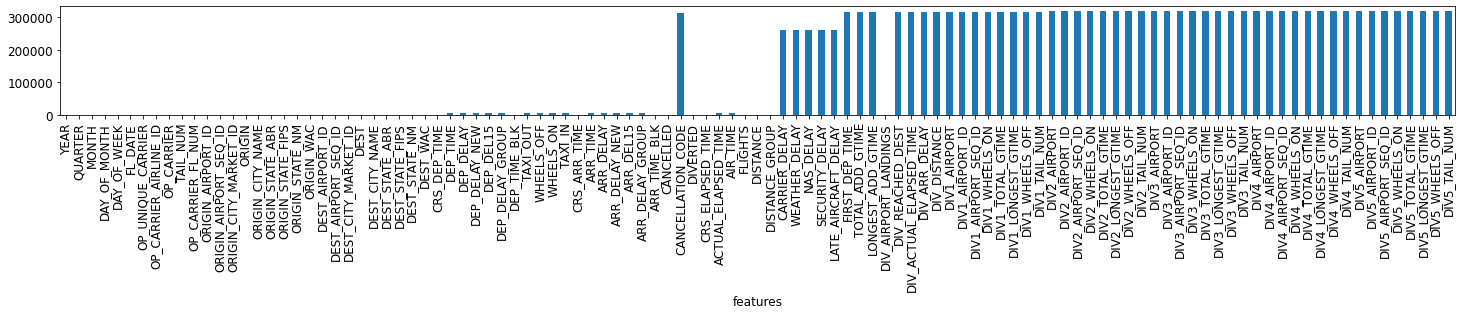

<matplotlib.axes._subplots.AxesSubplot at 0x7f4fe58653d0>

In [0]:
# Assessing for Nulls in Flight Data
flight_df_sample_missing_counts = count_missings(flight_df_sample)

flight_df_sample_missing_counts_pdf = pd.DataFrame({
    "features": list(flight_df_sample_missing_counts.columns),
    "number_of_nulls": list(flight_df_sample_missing_counts.iloc[0])})

flight_df_sample_missing_counts_pdf.set_index("features",drop=True,inplace=True)
ax = flight_df_sample_missing_counts_pdf.plot.bar(figsize=(25,2))
ax.get_legend().remove()
plt.axes(ax)

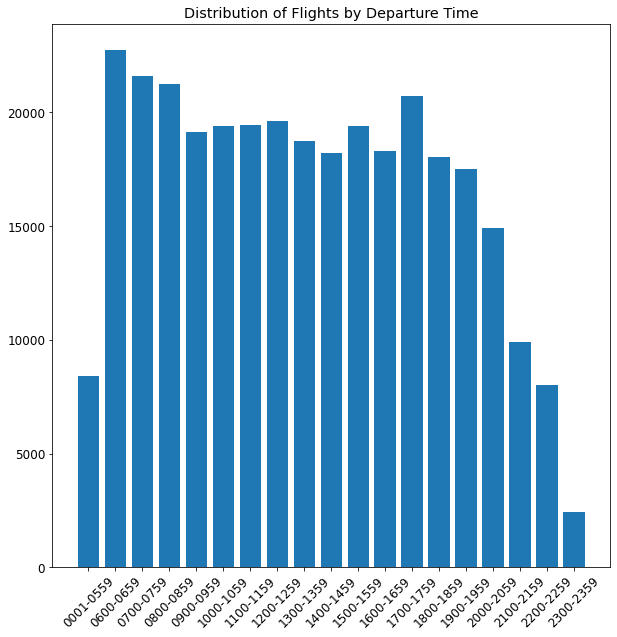

In [0]:
# Distribution of flights by departure time (histogram)
plt.clf()
pdDF = flight_df_sample.groupBy("DEP_TIME_BLK").count().orderBy('DEP_TIME_BLK').toPandas()
plt.figure(figsize=(10,10))
plt.bar(pdDF['DEP_TIME_BLK'], pdDF['count'])
# plt.xticks(np.arange(0, 2, step=1))
plt.xticks(rotation=45)
plt.title('Distribution of Flights by Departure Time')
display()

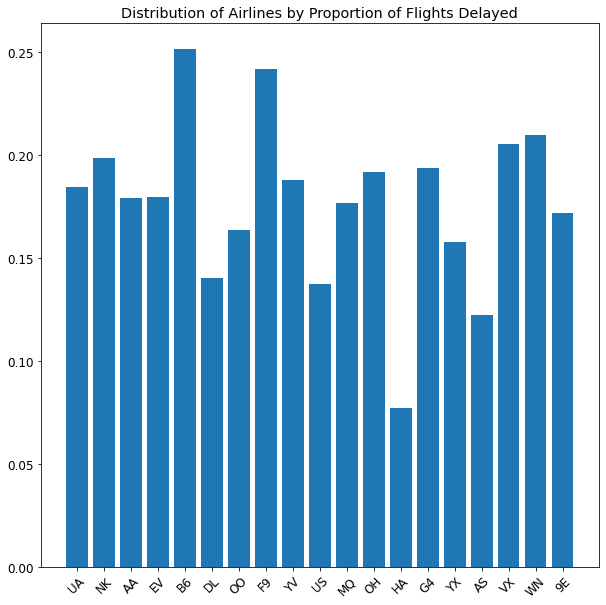

In [0]:
# Distribution of airlines by proportion of flights delayed (histogram)
AGG = flight_df_sample.groupBy("OP_CARRIER").agg({'OP_CARRIER':'count','DEP_DEL15':'sum'})
AGG = AGG.withColumn("Proportion_Delayed",col("sum(DEP_DEL15)")/col('count(OP_CARRIER)'))

pdDF = AGG.toPandas()
plt.clf()
plt.figure(figsize=(10,10))
plt.bar(pdDF['OP_CARRIER'], pdDF['Proportion_Delayed'])
# plt.xticks(np.arange(0, 2, step=1))
plt.xticks(rotation=45)
plt.title('Distribution of Airlines by Proportion of Flights Delayed')
display()

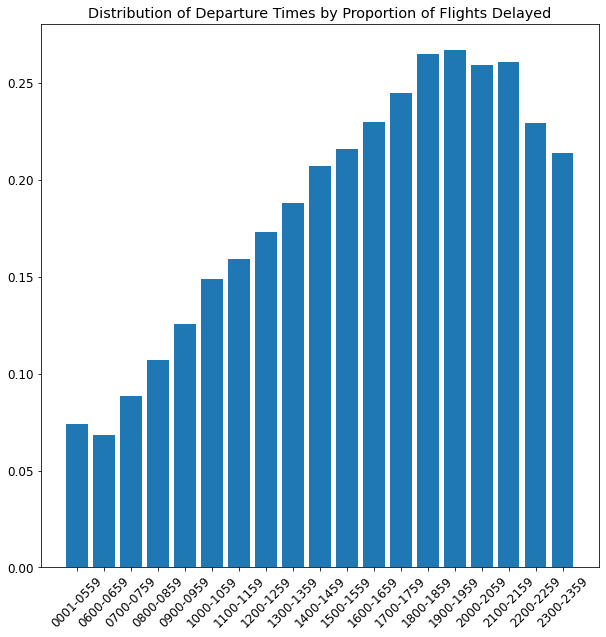

In [0]:
# Distribution of departure times by proportion of flights delayed (histogram)
AGG = flight_df_sample.groupBy("DEP_TIME_BLK").agg({'DEP_TIME_BLK':'count','DEP_DEL15':'sum'})
AGG = AGG.withColumn("Proportion_Delayed",col("sum(DEP_DEL15)")/col('count(DEP_TIME_BLK)'))

pdDF = AGG.toPandas().sort_values('DEP_TIME_BLK')
plt.clf()
plt.figure(figsize=(10,10))
plt.bar(pdDF['DEP_TIME_BLK'], pdDF['Proportion_Delayed'])
# plt.xticks(np.arange(0, 2, step=1))
plt.xticks(rotation=45)
plt.title('Distribution of Departure Times by Proportion of Flights Delayed')
display()

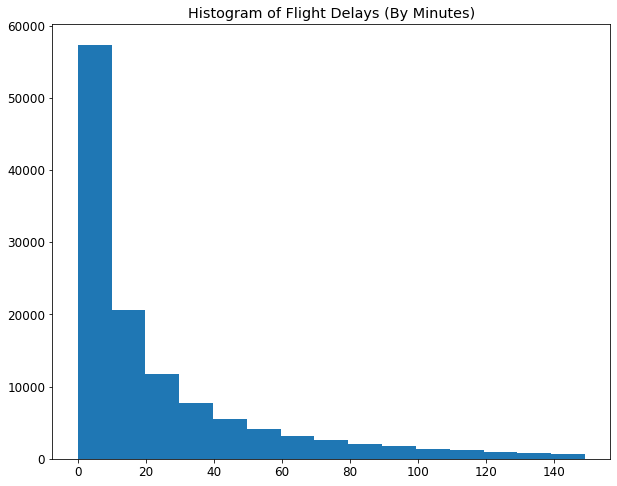

In [0]:
# Distribution of flight delays by minutes (histogram)
plt.clf()
pdDF = flight_df_sample.filter(col('DEP_DELAY') >= 0).filter(col('DEP_DELAY') <150).toPandas()
plt.figure(figsize=(10,8))
plt.hist(pdDF['DEP_DELAY'], bins=15)
plt.title('Histogram of Flight Delays (By Minutes)')
display()

In [0]:
# Count delayed vs. not-delayed vs. null values (table)
tot = flight_df_sample.count()

flight_df_sample.groupBy("DEP_DEL15") \
  .count() \
  .withColumnRenamed('count', 'COUNTS') \
  .withColumn('PERCENTAGE_OF_TOTAL', (F.col('COUNTS') / tot) * 100 ) \
  .orderBy('COUNTS', ascending=False).show()

+---------+------+-------------------+
DEP_DEL15|COUNTS|PERCENTAGE_OF_TOTAL|
+---------+------+-------------------+
 0.0|255901| 80.49074312890421|
 1.0| 57195| 17.990035417046734|
 null| 4830| 1.5192214540490554|
+---------+------+-------------------+

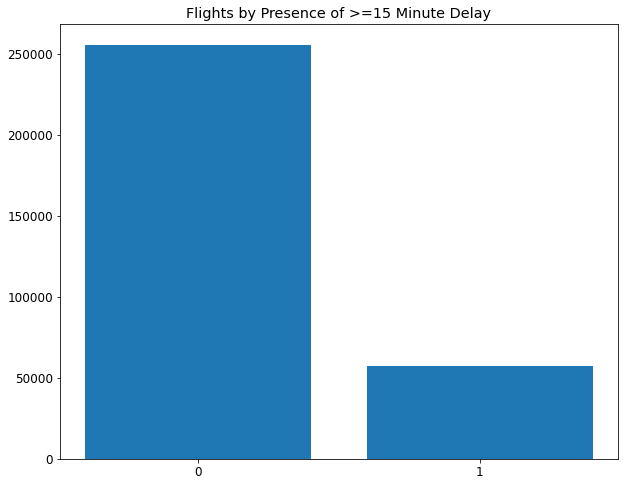

In [0]:
# Count delayed vs. not-delayed (bar chart)
plt.clf()
pdDF = flight_df_sample.groupBy("DEP_DEL15").count().orderBy('count', ascending=False).toPandas()
plt.figure(figsize=(10,8))

plt.bar(pdDF['DEP_DEL15'], pdDF['count'])
plt.xticks(np.arange(0, 2, step=1))

plt.title('Flights by Presence of >=15 Minute Delay')
display()

In [0]:
# Dataframe to pandas
MASTER_PD = flight_df_sample.toPandas()

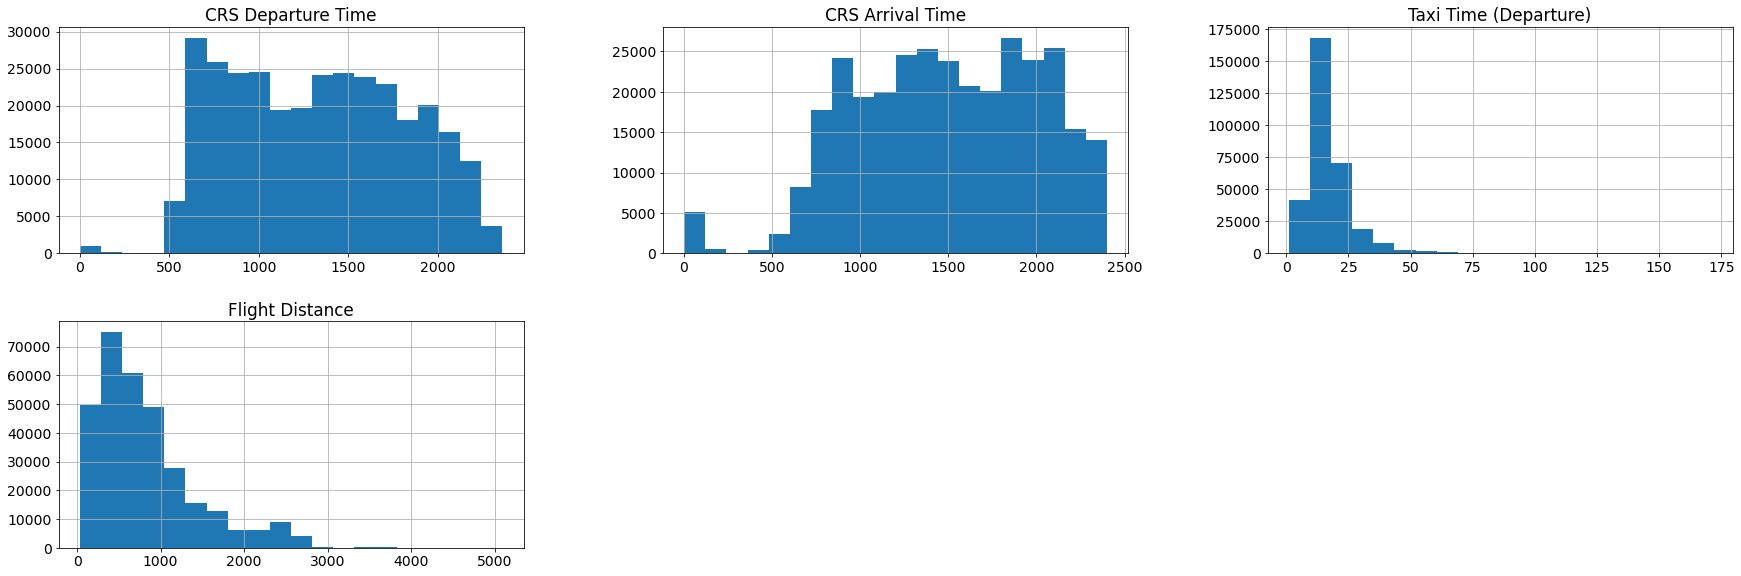

In [0]:
# Distribution of key features - counts (bar chart)
plt.rcParams.update({'font.size': 14})

MASTER_PD = MASTER_PD.rename(columns = {
  'OP_CARRIER': 'Airline Carrier'  
  ,'ORIGIN': 'Originating Airport'
  ,'CRS_DEP_TIME': 'CRS Departure Time'
  ,'CRS_ARR_TIME': 'CRS Arrival Time'
  ,'TAXI_OUT': 'Taxi Time (Departure)'
  ,'DISTANCE': 'Flight Distance'
})

FIELDS = [
          'CRS Departure Time' ,'CRS Arrival Time',
           'Taxi Time (Departure)','Flight Distance'
         ]
MASTER_PD[FIELDS].hist(figsize=(30,15), bins=20, layout=(3,3))
plt.show()

#### Section 3 - Feature Engineering and Transformation

In this section, we start by joining the weather data to the airline data.  The approach used to do this essentially entails bringing in an external table which includes the latitude and longitude of each airport and then leveraging that information, combined with the with the weather data (which includes the latitude and longitdue of each weather station), to generate a lookup table which contains the closest weather station for each airport. We then join the weather data to the airline data by finding, for each flight, the the most recent weather report (from the weather station closest to the airport associated with the flight) leading up to the flight's scheduled departure time which is not, however, within the 2 hours preceding the scheduled departure time.  After joining the weather dataset to the flight data, we then developed features pertaining to each plane's prior flight. Due to the requirement to be able to predict whether or not a flight would be delayed at least 2 hours prior to the scheduled departure time, information which is only obtainable in the 2 hours leading up to the a given flight is **not** used.

Below is a summary of the features which were ultimately used in the model, as well as additional amplifying information. It is worth noting that each dataset has more columns available to potentially be used as features. In a more exhaustive exercise, we would spend time with subject matter experts to narrow down the features to those most likely to be relevant. For brevity sake, we have narrowed down the columns based on i) availability of clear definition of the column (this ruled out ~165 of the 177 weather features), and ii) personal empirical evidence of flight delays. Lastly, replacement of null values, as well as additional transformations are performed and discussed in greater detail in the following section.


Key features from the weather dataset the analysis focused on include: (Ref 3)
- Wind speed: how fast air is moving past a certain point (fourth field parsed from dataset column)
- Cloud ceiling: height above the ground or water of the base of the lowest layer of cloud below 6,000 metres (20,000 feet) covering more than half the sky (fifth field parsed from dataset column)
- Visibility: measure of the distance at which an object or light can be clearly discerned (fourth field parsed from dataset column)
- Temperature: degree of hotness or coldness (first field parsed from dataset column)
- Dew Point: temperature the air needs to be cooled to (at constant pressure) in order to achieve a relative humidity (RH) of 100% (first field parsed from dataset column) 

Key features from the flight dataset the analysis focused on include: (Ref 3)
- Origin - The airport of origin (one-hot encoded in subsequent section)
- Destination - The destination airport (one-hot encoded in subsequent section)
- Month - The month during which the flight is schedule to depart (one-hot encoded in subsequent section)
- Day of week - The day of the week on which the flight is scheduled to depart (one-hot encoded in subsequent section)
- Carrier - The airline carrier associated with the flight (one-hot encoded in subsequent section)
- CRS departure time - scheduled departure time (expressed as minutes into the day)
- CRS arrival time - scheduled arrival time (expressed as minutes into the day)
- Distance - the distance of the flight
- Taxi time (departure) - time duration elapsed between departure from the origin airport gate and wheels off
- Flight distance - distance between two airports


Derived columns were created to indicate potential relationships that can be observed when features are combined. Most of these features entail obtaining information from a plane's previous flight. However, it is worth noting that a given plane's prior flight's information is only used when that information would be knowable outside of the two hours prior to the departure in question. As an example, the prior flight arrival delay amount will not be used if the prior flight's arrival occured within the 2 hours leading up the subsequent departure. In these instances, a default value of -999 is inserted.  In instances where there is no prior flight information for the plane in question (i.e. it is the first flight of the day), these fields are left as null initially and later filled in with a -500.  By incorporating the actual values when they are available (and it is appropriate to use them) with default values when the information is not available or capable of being used, we essentially combine a categorical variable with a continuous variable (more discussed on this in the subsequent section). Laslty, although we evaluated the amount of time between the prior flight's scheduled arrival time and the current flight's scheduled departure time, we ultimately excluded this variable from the final dataset becasue in subsequent EDA, we noticed a number of instances where the CRS arrival time for the plane's prior flight occured after the plane's next flight's CRS departure time. This may be because the CRS arrival time is updated in the computer system (i.e. CRS) as the delay becomes more apparent; however, this is also not known to be the case. Due to the uncertainty around this aspect of the data and the risk of potential data leakage, this variable was excluded.

- Prior flight origin - the airport from which the plane previously departed (one-hot encoded)
- Time difference between scheduled departure and actual prior arrival time - the amount of time (in minutes) between a scheduled departure time and the associated plane's actual arrival time for the preceding flight.
- Time difference between scheduled departure and actual prior departure time - the amount of time (in minutes) between a scheduled departure time and the associated plane's actual departure time for the preceding flight.
- Prior flight departure delay amount - the amount of time (in minutes) associated with a plane's prior flight's departure delay.
- Prior flight arrival delay amount - the amount of time (in minutes) associated with a plane's prior flight's arrival delay.
- Plane flight sequence - the sequence of a given plane's flight relative to all other flights for that plane on that day

Further research could consider more transformations derived from the prior flight information, as well as additional individual transformations (e.g. log). These were not included in this exercise due to time constraints. 

Ref 3: Technical definitions converted into common language, general intent found from Wikipedia, as of August 2021. Field parsing references from source file, based on best estimate for correct number.

###### Joining Weather Data to Airline Data

In [0]:
# Creating lookup table which has the closest weather station for each airport

# Creating Weater Station ID with LAT/LONG Lookup Table
df_weather_station_lu = df_weather.select('STATION','LATITUDE','LONGITUDE').distinct()

# Creating a field or Lat and Long in Airport Lookup Table
split_col = pyspark.sql.functions.split(airport_mapping_df['coordinates'], ',')
airport_mapping_df = airport_mapping_df.withColumn('LONG', split_col.getItem(0))
airport_mapping_df = airport_mapping_df.withColumn('LAT', split_col.getItem(1))

# Taking Only Relevant Fields from Airport LU Table
airport_mapping_df_trimmed = airport_mapping_df.select('iata_code', 'LAT', 'LONG').na.drop(how='any')

# Cross Join of Weather Station LU table and Airport Code LU Table
master_lu = df_weather_station_lu.crossJoin(airport_mapping_df_trimmed)

# Convert Other Lat/Long columns to Float
master_lu = master_lu.withColumn('LAT', master_lu.LAT.cast("float")).withColumn('LONG', master_lu.LONG.cast("float"))

# Obtaining Distance between Airport and Weather Station
master_lu = master_lu.withColumn("Distance", haversine_udf(col("LATITUDE"),col("LONGITUDE"),col("LAT"),col("LONG")))
                      
# Creating Master Lookup Table (between Airports and Weather Stations) by Keeping the Closest Weather Station for Each Airport
master_lu = master_lu.select("STATION", "DISTANCE", "iata_code", F.row_number().over(Window.partitionBy("iata_code").orderBy(col("DISTANCE"))).alias("rowNum")).filter(col('rowNum') == 1)

In [0]:
# Checkpoint

# # Saving station to airport lookup table
# dbutils.fs.rm(FILE_PATH + "airport_weather_station_lu_master.parquet", recurse=True)
# master_lu.write.parquet(FILE_PATH + "airport_weather_station_lu_master.parquet")

# # Reading in master lookup table
# master_lu = spark.read.parquet(FILE_PATH + "airport_weather_station_lu_master.parquet")

In [0]:
# Select relevant weather features (variable is named as a sample, as this was just a sample of weather data during initial development)
df_weather_sample = df_weather.select('STATION','DATE','LATITUDE','LONGITUDE','NAME','WND','CIG','VIS','TMP','DEW','SLP').sample(1.0)

In [0]:
# Transforming datetime column in weather table so we have a clean date field and the time of day expressed in minutes into the day

# Splitting Date and Time in the Weather Table Table
split_col = pyspark.sql.functions.split(df_weather_sample['DATE'], 'T')
df_weather_sample = df_weather_sample.withColumn('DATE_2', split_col.getItem(0))
split_col = pyspark.sql.functions.split(df_weather_sample['DATE_2'], ' ')
df_weather_sample = df_weather_sample.withColumn('DATE_TRIMMED', split_col.getItem(0))
df_weather_sample = df_weather_sample.withColumn('TIME', split_col.getItem(1))
df_weather_sample = df_weather_sample.drop('DATE_2')

# Splitting Date and Time in the Weather Table Table
split_col = pyspark.sql.functions.split(df_weather_sample['TIME'], ':')
df_weather_sample = df_weather_sample.withColumn('HOUR', split_col.getItem(0))
df_weather_sample = df_weather_sample.withColumn('MINUTES', split_col.getItem(1))

# Adding Hours to Minutes to create a variable which frames the time of the weather report as the number of minutes into the day
df_weather_sample = df_weather_sample.withColumn('HOUR', df_weather_sample.HOUR.cast("float")).withColumn('MINUTES', df_weather_sample.MINUTES.cast("float"))
df_weather_sample = df_weather_sample.withColumn("TOTAL_MINUTES_WEATHER_DF",(col("HOUR")* 60)+col("MINUTES"))

In [0]:
# Renaming column to prevent duplicate names later on when joining tables
df_weather_sample = df_weather_sample.withColumnRenamed("STATION","STATION_WEATHER_DF")

In [0]:
# Joining weather data with master lookup table so that we can bring in the closest airport to each weather station

# This will allow us to join the weather data directly to the flights data later on
df_weather_sample_with_AP_codes = df_weather_sample.join(master_lu.select('STATION','DISTANCE','iata_code'), [df_weather_sample.STATION_WEATHER_DF == master_lu.STATION], 'inner')

# Remaining column to prevent duplicate names later on when joining tables
df_weather_sample_with_AP_codes = df_weather_sample_with_AP_codes.withColumnRenamed("DISTANCE","DISTANCE_WEATHER_DF")

In [0]:
# Transforming flight data frame time/date fields

# Pulling Hours and Minutes out of CRS_DEP_TIME variable in flights data and then converting that to total minutes in day
df_flights = df_flights.withColumn('DEPARTURE_HOUR', substring(df_flights.CRS_DEP_TIME, -4,2 )) 
df_flights = df_flights.withColumn('DEPARTURE_MINUTES', substring(df_flights.CRS_DEP_TIME, -2,2 )) 

df_flights = df_flights.withColumn('DEPARTURE_HOUR', df_flights.DEPARTURE_HOUR.cast("float")) \
                       .withColumn('DEPARTURE_MINUTES', df_flights.DEPARTURE_MINUTES.cast("float"))
df_flights = df_flights.withColumn("TOTAL_MINUTES",(col("DEPARTURE_HOUR")* 60)+col("DEPARTURE_MINUTES"))

# Pulling Hours and Minutes out of DEP_TIME variable in flights data and then converting that to total minutes in day
df_flights = df_flights.withColumn('DEPARTURE_HOUR_ACTUAL', substring(df_flights.DEP_TIME, -4,2 )) 
df_flights = df_flights.withColumn('DEPARTURE_MINUTES_ACTUAL', substring(df_flights.DEP_TIME, -2,2 )) 

df_flights = df_flights.withColumn('DEPARTURE_HOUR_ACTUAL', df_flights.DEPARTURE_HOUR_ACTUAL.cast("float")) \
                       .withColumn('DEPARTURE_MINUTES_ACTUAL', df_flights.DEPARTURE_MINUTES_ACTUAL.cast("float"))
df_flights = df_flights.withColumn("TOTAL_MINUTES_ACTUAL",(col("DEPARTURE_HOUR_ACTUAL")* 60)+col("DEPARTURE_MINUTES_ACTUAL"))


# Pulling Hours and Minutes out of CRS_ARR_TIME variable in flights data and then converting that to total minutes in day
df_flights = df_flights.withColumn('ARRIVAL_HOUR_CRS', substring(df_flights.CRS_ARR_TIME, -4,2 )) 
df_flights = df_flights.withColumn('ARRIVAL_MINUTES_CRS', substring(df_flights.CRS_ARR_TIME, -2,2 )) 

df_flights = df_flights.withColumn('ARRIVAL_HOUR_CRS', df_flights.ARRIVAL_HOUR_CRS.cast("float")) \
                       .withColumn('ARRIVAL_MINUTES_CRS', df_flights.ARRIVAL_MINUTES_CRS.cast("float"))
df_flights = df_flights.withColumn("TOTAL_MINUTES_ARRIVAL_CRS",(col("ARRIVAL_HOUR_CRS")* 60)+col("ARRIVAL_MINUTES_CRS"))


# Pulling Hours and Minutes out of ARR_TIME variable in flights data and then converting that to total minutes in day
df_flights = df_flights.withColumn('ARRIVAL_HOUR_ACTUAL', substring(df_flights.ARR_TIME, -4,2 )) 
df_flights = df_flights.withColumn('ARRIVAL_MINUTES_ACTUAL', substring(df_flights.ARR_TIME, -2,2 )) 

df_flights = df_flights.withColumn('ARRIVAL_HOUR_ACTUAL', df_flights.ARRIVAL_HOUR_ACTUAL.cast("float")) \
                       .withColumn('ARRIVAL_MINUTES_ACTUAL', df_flights.ARRIVAL_MINUTES_ACTUAL.cast("float"))
df_flights = df_flights.withColumn("TOTAL_MINUTES_ARRIVAL_ACTUAL",(col("ARRIVAL_HOUR_ACTUAL")* 60)+col("ARRIVAL_MINUTES_ACTUAL"))


In [0]:
# Adding unique identifier for each flight
w=Window.orderBy(lit(1))
df_flights = df_flights.withColumn("seq_sk",row_number().over(w))

In [0]:
# Joining flights data to weather data - (joining closest weather station where weather report is the same day as the flight but at least 2 hours before scheduled departure)                         
cond = [(df_weather_sample_with_AP_codes.iata_code == df_flights.ORIGIN) 
        ,(df_weather_sample_with_AP_codes.DATE_TRIMMED == df_flights.FL_DATE)
        ,(df_weather_sample_with_AP_codes.TOTAL_MINUTES_WEATHER_DF < df_flights.TOTAL_MINUTES - 120)]
MASTER = df_flights.join(df_weather_sample_with_AP_codes.select('DATE_TRIMMED', 'TOTAL_MINUTES_WEATHER_DF', 'DISTANCE_WEATHER_DF','iata_code',
                                                                'WND',  'CIG', 'VIS', 'TMP', 'DEW'), cond, 'left')


In [0]:
# Creating a column that reflects the difference in minutes between the flight and the weather report
MASTER = MASTER.withColumn("TIME_DIFF",col("TOTAL_MINUTES_WEATHER_DF")-col('TOTAL_MINUTES'))


# Keeps the weather report which most immediately precedes the scheduled flight departure, as well as keeps only the relevant flight and weather columns
MASTER = MASTER.select('MONTH', 'FL_DATE', 'OP_CARRIER', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'TAIL_NUM',
                       'ORIGIN', 'TAXI_OUT', 'DISTANCE', 'DEST', 'DEST_STATE_ABR', 'DAY_OF_WEEK', 
                       'CRS_DEP_TIME', 'DEP_TIME_BLK', 'TOTAL_MINUTES', 'TOTAL_MINUTES_ACTUAL', 'DEP_DEL15', 'DEP_DELAY', 'DEP_DELAY_NEW', 'CANCELLED', 'DIVERTED',
                       'CRS_ARR_TIME', 'TOTAL_MINUTES_ARRIVAL_CRS', 'TOTAL_MINUTES_ARRIVAL_ACTUAL', 'ARR_DEL15', 'ARR_DELAY', 'ARR_DELAY_NEW', 
                       'WND', 'CIG', 'VIS', 'TMP', 'DEW', 'DISTANCE_WEATHER_DF', 'TOTAL_MINUTES_WEATHER_DF', 'TIME_DIFF', F.row_number() \
                       .over(Window.partitionBy('seq_sk') \
                       .orderBy(F.abs(MASTER.TIME_DIFF))).alias("rowNum")) \
                       .filter((col('rowNum') == 1) | (col('rowNum').isNull()))

In [0]:
# Confirm join integrity

# Creating Column to indicate whether or not join to weather data was successful 
MASTER = MASTER.withColumn("WEATHER_NOT_NULL", F.col("TOTAL_MINUTES_WEATHER_DF").isNotNull())

# Evaluating Join Effectiveness
MASTER.groupBy("WEATHER_NOT_NULL").count().orderBy('count', ascending=False).show()

# Counting records in DF to make sure record count is the same as in flights data (shown below) 
MASTER.count()

+----------------+--------+
WEATHER_NOT_NULL| count|
+----------------+--------+
 true|31359891|
 false| 386950|
+----------------+--------+

Out[41]: 31746841

In [0]:
# Checkpoint - saving parquet file
# dbutils.fs.rm(FILE_PATH + "MASTER_POSTJOINED.parquet", recurse=True)
# MASTER.write.parquet(FILE_PATH + "MASTER_POSTJOINED.parquet")

# # Reading in from parquet file
# MASTER = spark.read.parquet(FILE_PATH + "MASTER_POSTJOINED.parquet")

###### Weather and Prior Flight Feature Engineering

In [0]:
# Parsing weather data columns

split_col = pyspark.sql.functions.split(MASTER['WND'], ',')
MASTER = MASTER.withColumn('WND_1', split_col.getItem(0))
MASTER = MASTER.withColumn('WND_2', split_col.getItem(1))
MASTER = MASTER.withColumn('WND_3', split_col.getItem(2))
MASTER = MASTER.withColumn('WND_4', split_col.getItem(3))
MASTER = MASTER.withColumn('WND_5', split_col.getItem(4))

split_col = pyspark.sql.functions.split(MASTER['CIG'], ',')
MASTER = MASTER.withColumn('CIG_1', split_col.getItem(0))
MASTER = MASTER.withColumn('CIG_2', split_col.getItem(1))
MASTER = MASTER.withColumn('CIG_3', split_col.getItem(2))
MASTER = MASTER.withColumn('CIG_4', split_col.getItem(3))

split_col = pyspark.sql.functions.split(MASTER['VIS'], ',')
MASTER = MASTER.withColumn('VIS_1', split_col.getItem(0))
MASTER = MASTER.withColumn('VIS_2', split_col.getItem(1))
MASTER = MASTER.withColumn('VIS_3', split_col.getItem(2))
MASTER = MASTER.withColumn('VIS_4', split_col.getItem(3))

split_col = pyspark.sql.functions.split(MASTER['TMP'], ',')
MASTER = MASTER.withColumn('TMP_1', split_col.getItem(0))
MASTER = MASTER.withColumn('TMP_2', split_col.getItem(1))

split_col = pyspark.sql.functions.split(MASTER['DEW'], ',')
MASTER = MASTER.withColumn('DEW_1', split_col.getItem(0))
MASTER = MASTER.withColumn('DEW_2', split_col.getItem(1))

In [0]:
# Creatining weather features

MASTER = MASTER.withColumn("WIND_SPEED", MASTER["WND_4"].cast(IntegerType()))
MASTER = MASTER.withColumn("WIND_SPEED", when(col("WND_1") == '999', None).otherwise(col("WIND_SPEED")))

MASTER = MASTER.withColumn("CLOUD_CEILING", MASTER["CIG_1"].cast(IntegerType()))
MASTER = MASTER.withColumn("CLOUD_CEILING", when(col("CLOUD_CEILING") == 99999, None).otherwise(col("CLOUD_CEILING")))

MASTER = MASTER.withColumn("VISIBILITY", MASTER["VIS_1"].cast(IntegerType()))

MASTER = MASTER.withColumn('TMP_1_SIGN', substring(MASTER.TMP_1, 1,1 )) 
MASTER = MASTER.withColumn('TMP_1', substring(MASTER.TMP_1, 2,4 )) 
MASTER = MASTER.withColumn("TMP_1", MASTER["TMP_1"].cast(IntegerType()))
MASTER = MASTER.withColumn("TEMPERATURE", when(MASTER.TMP_1_SIGN == '+', MASTER.TMP_1) \
                                         .when(MASTER.TMP_1_SIGN == '-',MASTER.TMP_1 * -1))

MASTER = MASTER.withColumn('DEW_1_SIGN', substring(MASTER.DEW_1, 1,1 )) 
MASTER = MASTER.withColumn('DEW_1', substring(MASTER.DEW_1, 2,4 )) 
MASTER = MASTER.withColumn("DEW_1", MASTER["DEW_1"].cast(IntegerType()))
MASTER = MASTER.withColumn("DEW_POINT", when(MASTER.DEW_1_SIGN == '+', MASTER.DEW_1) \
                                       .when(MASTER.DEW_1_SIGN == '-',MASTER.DEW_1 * -1))



In [0]:
# Obtaining information for each plane's prior flight and flight sequence for day

# Plane's prior flight - arrival information
MASTER = MASTER.withColumn('PRIOR_FLIGHT_ARR_DELAY_AMT_NEW', 
                                       F.lag('ARR_DELAY_NEW').over(Window.partitionBy('FL_DATE', 'TAIL_NUM').orderBy('CRS_DEP_TIME')))
MASTER = MASTER.withColumn('PRIOR_FLIGHT_ARR_DELAY_AMT', 
                                       F.lag('ARR_DELAY').over(Window.partitionBy('FL_DATE', 'TAIL_NUM').orderBy('CRS_DEP_TIME')))
MASTER = MASTER.withColumn('PRIOR_FLIGHT_ARR_DELAY15_IND', 
                                       F.lag('ARR_DEL15').over(Window.partitionBy('FL_DATE', 'TAIL_NUM').orderBy('CRS_DEP_TIME')))
MASTER = MASTER.withColumn('PRIOR_FLIGHT_CRS_ARR_TOTAL_MINUTES', 
                                       F.lag('TOTAL_MINUTES_ARRIVAL_CRS').over(Window.partitionBy('FL_DATE', 'TAIL_NUM').orderBy('CRS_DEP_TIME')))
MASTER = MASTER.withColumn('PRIOR_FLIGHT_ARR_TOTAL_MINUTES', 
                                       F.lag('TOTAL_MINUTES_ARRIVAL_ACTUAL').over(Window.partitionBy('FL_DATE', 'TAIL_NUM').orderBy('CRS_DEP_TIME')))

# Plane's prior flight - departure information
MASTER = MASTER.withColumn('PRIOR_FLIGHT_DEP_DELAY_AMT_NEW', 
                                       F.lag('DEP_DELAY_NEW').over(Window.partitionBy('FL_DATE', 'TAIL_NUM').orderBy('CRS_DEP_TIME')))
MASTER = MASTER.withColumn('PRIOR_FLIGHT_DEP_DELAY_AMT', 
                                       F.lag('DEP_DELAY').over(Window.partitionBy('FL_DATE', 'TAIL_NUM').orderBy('CRS_DEP_TIME')))
MASTER = MASTER.withColumn('PRIOR_FLIGHT_DEP_DELAY15_IND', 
                                       F.lag('DEP_DEL15').over(Window.partitionBy('FL_DATE', 'TAIL_NUM').orderBy('CRS_DEP_TIME')))
MASTER = MASTER.withColumn('PRIOR_FLIGHT_DEP_TOTAL_MINUTES', 
                                       F.lag('TOTAL_MINUTES_ACTUAL').over(Window.partitionBy('FL_DATE', 'TAIL_NUM').orderBy('CRS_DEP_TIME')))

# Plane's prior flight - other information
MASTER = MASTER.withColumn('PRIOR_FLIGHT_DISTANCE', 
                                       F.lag('DISTANCE').over(Window.partitionBy('FL_DATE', 'TAIL_NUM').orderBy('CRS_DEP_TIME')))
MASTER = MASTER.withColumn('PRIOR_FLIGHT_CANCELLED_IND', 
                                       F.lag('CANCELLED').over(Window.partitionBy('FL_DATE', 'TAIL_NUM').orderBy('CRS_DEP_TIME')))
MASTER = MASTER.withColumn('PRIOR_FLIGHT_DIVERTED_IND', 
                                       F.lag('DIVERTED').over(Window.partitionBy('FL_DATE', 'TAIL_NUM').orderBy('CRS_DEP_TIME')))
MASTER = MASTER.withColumn('PRIOR_FLIGHT_ORIGIN', 
                                       F.lag('ORIGIN').over(Window.partitionBy('FL_DATE', 'TAIL_NUM').orderBy('CRS_DEP_TIME')))

# Plane's flight sequence for day
MASTER = MASTER.withColumn('PLANE_FLIGHT_SEQUENCE', 
                                       F.row_number().over(Window.partitionBy('FL_DATE', 'TAIL_NUM').orderBy('CRS_DEP_TIME')))

In [0]:
# Creating features which compare plane's current flight information to plane's prior flight information

MASTER = MASTER.withColumn("TIME_DIFF_BT_CRS_DEP_AND_PRIOR_ARR", col("TOTAL_MINUTES")-col('PRIOR_FLIGHT_ARR_TOTAL_MINUTES'))
MASTER = MASTER.withColumn("TIME_DIFF_BT_CRS_DEP_AND_PRIOR_CRS_ARR", col("TOTAL_MINUTES")-col('PRIOR_FLIGHT_CRS_ARR_TOTAL_MINUTES'))
MASTER = MASTER.withColumn("TIME_DIFF_BT_CRS_DEP_AND_PRIOR_DEP", col("TOTAL_MINUTES")-col('PRIOR_FLIGHT_DEP_TOTAL_MINUTES'))


MASTER = MASTER.withColumn('PRIOR_FLIGHT_ARR_DELAY_AMT', MASTER['PRIOR_FLIGHT_ARR_DELAY_AMT'].cast(IntegerType()))
MASTER = MASTER.withColumn('PRIOR_FLIGHT_ARR_DELAY_AMT_NEW', MASTER['PRIOR_FLIGHT_ARR_DELAY_AMT_NEW'].cast(IntegerType()))
MASTER = MASTER.withColumn('PRIOR_FLIGHT_ARR_DELAY15_IND', MASTER['PRIOR_FLIGHT_ARR_DELAY15_IND'].cast(IntegerType()))

MASTER = MASTER.withColumn("PRIOR_FLIGHT_ARR_DELAY_AMT", 
                                       when(col('TIME_DIFF_BT_CRS_DEP_AND_PRIOR_ARR') < 120, -999).otherwise(col('PRIOR_FLIGHT_ARR_DELAY_AMT')))
MASTER = MASTER.withColumn("PRIOR_FLIGHT_ARR_DELAY_AMT_NEW", 
                                       when(col('TIME_DIFF_BT_CRS_DEP_AND_PRIOR_ARR') < 120, -999).otherwise(col('PRIOR_FLIGHT_ARR_DELAY_AMT_NEW')))
MASTER = MASTER.withColumn("PRIOR_FLIGHT_ARR_DELAY15_IND", 
                                       when(col('TIME_DIFF_BT_CRS_DEP_AND_PRIOR_ARR') < 120, -1).otherwise(col('PRIOR_FLIGHT_ARR_DELAY15_IND')))


MASTER = MASTER.withColumn('PRIOR_FLIGHT_DEP_DELAY_AMT', MASTER['PRIOR_FLIGHT_DEP_DELAY_AMT'].cast(IntegerType()))
MASTER = MASTER.withColumn('PRIOR_FLIGHT_DEP_DELAY_AMT_NEW', MASTER['PRIOR_FLIGHT_DEP_DELAY_AMT_NEW'].cast(IntegerType()))
MASTER = MASTER.withColumn('PRIOR_FLIGHT_DEP_DELAY15_IND', MASTER['PRIOR_FLIGHT_ARR_DELAY15_IND'].cast(IntegerType()))

MASTER = MASTER.withColumn('PRIOR_FLIGHT_DEP_DELAY_AMT', 
                                       when(col('TIME_DIFF_BT_CRS_DEP_AND_PRIOR_DEP') < 120, -999).otherwise(col('PRIOR_FLIGHT_DEP_DELAY_AMT')))
MASTER = MASTER.withColumn("PRIOR_FLIGHT_DEP_DELAY_AMT_NEW", 
                                       when(col('TIME_DIFF_BT_CRS_DEP_AND_PRIOR_DEP') < 120, -999).otherwise(col('PRIOR_FLIGHT_DEP_DELAY_AMT_NEW')))
MASTER = MASTER.withColumn("PRIOR_FLIGHT_DEP_DELAY15_IND", 
                                       when(col('TIME_DIFF_BT_CRS_DEP_AND_PRIOR_DEP') < 120, -1).otherwise(col('PRIOR_FLIGHT_DEP_DELAY15_IND')))

MASTER = MASTER.withColumn("TIME_DIFF_BT_CRS_DEP_AND_PRIOR_DEP", 
                                       when(col('TIME_DIFF_BT_CRS_DEP_AND_PRIOR_DEP') < 120, -999).otherwise(col('TIME_DIFF_BT_CRS_DEP_AND_PRIOR_DEP')))
MASTER = MASTER.withColumn("TIME_DIFF_BT_CRS_DEP_AND_PRIOR_ARR", 
                                       when(col('TIME_DIFF_BT_CRS_DEP_AND_PRIOR_ARR') < 120, -999).otherwise(col('TIME_DIFF_BT_CRS_DEP_AND_PRIOR_ARR')))

In [0]:
# # Checkpoint - saving parquet file
# dbutils.fs.rm(FILE_PATH + "MASTER.parquet", recurse=True)
# MASTER.write.parquet(FILE_PATH + "MASTER.parquet")

# # Reading in from parquet file
# MASTER = spark.read.parquet(FILE_PATH + "MASTER.parquet")

# # # Sample of full dataset before filling nulls
# full_dataset_sample = MASTER.sample(.01).cache()
# dbutils.fs.rm(FILE_PATH + "MASTER_sample.parquet", recurse=True)
# full_dataset_sample.write.parquet(FILE_PATH + "MASTER_sample.parquet")

# Reading in from parquet file
# full_dataset_sample = spark.read.parquet(FILE_PATH + "MASTER_sample.parquet")

#### Section 4 - Additional EDA on Complete Dataframe and Prepartion for Modeling

In this section, we perform additional EDA on the complete dataset which has now the weather data, as well as the additional features that allow us to incorporate prior flight information for a given plane. As part of the EDA performed in this section, we assessed the remaining feature distributions (as we did with flight-related features above). As above, this was done to better understand the data being used in the model, as well as to identify extreme outliers so that they could be removed. Lastly, in this section, we also assessed for correlations between continous variables. However, this was done more to build a better understanding of the data, as no features were removed on the basis of strong correlations. The reason for this is because the primary objective of the model is prediction, not inference. More specifically, for this application, the models we evaluated are robust against multicollinearity and ommitting variables for this reason risks losing some amount of signal which is not correlated with another varible.

One particular item of interest in this section is the degree to which we were able to effectively join the weather data to the flight data. Specficially, we can see that we were able to join a weather report to ~99% of flights, where the weather station which provided the report was only several kilometers away from the airport. Further, the vast majority of these weather reports have a report time of between 2-4 hours before the scheduled departure time. As a result of the close phsyical and temporal proximity of the weather relative to the flight, the weather information is likely to be relevant.

In addition to performing EDA and removing outliers, in this section, we also perform several other transformations on the data. Those transformations include:

- one hot encoding - categorical columns into binary sparse vectors (required for proper algorithm processing) 
- convert label into label indices using the StringIndexer (required for proper algorithm processing)
- transform all features into a vector using VectorAssembler (required for proper algorithm processing)
- obtaining the class weights, so we can input these into our models to account for the class imbalance in the depenedent variable

Lastly, we address missing values in this section. Specifically, missing value treatment was handled according to one of three approaches per column: 
- imputing missing values with the mean value in instances where data is legitimately missing or assessed to be an outlier so extreme that it was entered in error.
- imputing missing values with a value which is intentionally out of range (relative to all other values which are not missing).  This is similar to what was done in instances where we are unable to use information from a previous flight due to that information being only obtainable within the 2 hours leading up to departure. As mentioned above, this has the effect of combining a continuous variable with a categorical one, wherein we essentially train the model to use the continuous information where available but allow the model to discern when this information isn't available (as opposed to simply removing the records or replacing it with a mean value).  Additionally, by providing two different values for when this information is not available based on the reason it is not available.  Specifically, by having multiple default values, we allow the model to discriminate between prior flight information not being available becasue it was a plane's first flight and it not being available due to the 2 hour time restriction.
- dropping any remaining records with a null (much of which is associated with the ~1.5% of records which have nulls in the dependent variable) .

###### EDA on Final Dataframe

In [0]:
# Dataframe to pandas
MASTER_PD = full_dataset_sample.toPandas()

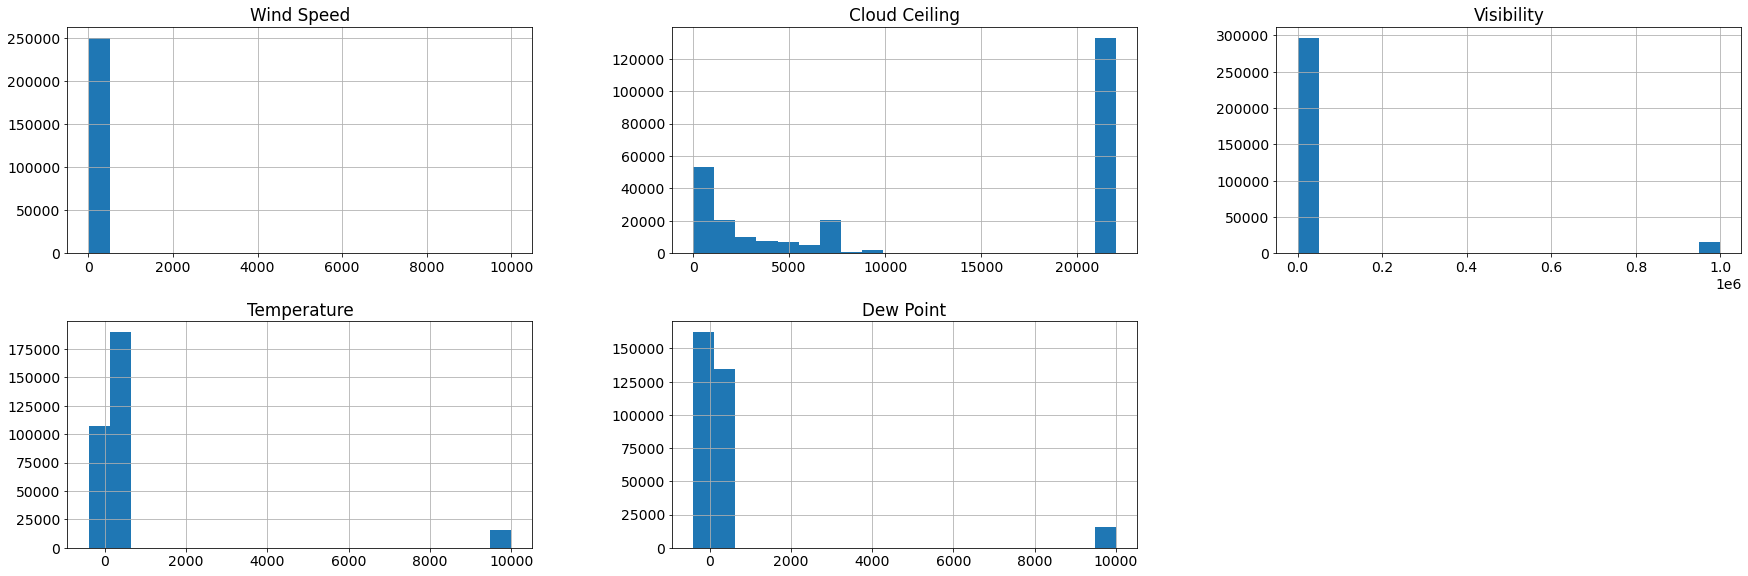

In [0]:
# Distribution of key features - counts (bar chart)
plt.rcParams.update({'font.size': 14})

MASTER_PD = MASTER_PD.rename(columns = {
  'WIND_SPEED': 'Wind Speed'
  ,'CLOUD_CEILING': 'Cloud Ceiling'
  ,'VISIBILITY': 'Visibility'
  ,'TEMPERATURE': 'Temperature'
  ,'DEW_POINT': 'Dew Point'
})

FIELDS = [
          'Wind Speed','Cloud Ceiling','Visibility','Temperature'
          ,'Dew Point'
         ]
MASTER_PD[FIELDS].hist(figsize=(30,15), bins=20, layout=(3,3))
plt.show()

In [0]:
# Removing outliers in weather data
full_dataset_sample = full_dataset_sample.withColumn("TEMPERATURE", 
                                       when(col('TEMPERATURE') > 2000, None).otherwise(col('TEMPERATURE')))
full_dataset_sample = full_dataset_sample.withColumn("DEW_POINT", 
                                       when(col('DEW_POINT') >2000, None).otherwise(col('DEW_POINT')))
full_dataset_sample = full_dataset_sample.withColumn("VISIBILITY", 
                                       when(col('VISIBILITY') > 20000, None).otherwise(col('VISIBILITY')))
full_dataset_sample = full_dataset_sample.withColumn("WIND_SPEED", 
                                       when(col('WIND_SPEED') > 500, None).otherwise(col('WIND_SPEED')))

In [0]:
# Convering dataframe with the above weather-related filters applied to pandas
MASTER_PD = full_dataset_sample.toPandas()

# Renaming columns to be more readable
MASTER_PD = MASTER_PD.rename(columns = {
  'OP_CARRIER': 'Airline Carrier'  
  ,'ORIGIN': 'Originating Airport'
  ,'CRS_DEP_TIME': 'CRS Departure Time'
  ,'CRS_ARR_TIME': 'CRS Arrival Time'
  ,'TAXI_OUT': 'Taxi Time (Departure)'
  ,'DISTANCE': 'Flight Distance'
  ,'WIND_SPEED': 'Wind Speed'
  ,'CLOUD_CEILING': 'Cloud Ceiling'
  ,'VISIBILITY': 'Visibility'
  ,'TEMPERATURE': 'Temperature'
  ,'DEW_POINT': 'Dew Point'
  ,'TIME_DIFF_BT_CRS_DEP_AND_PRIOR_ARR': 'Minutes Between CRS Departure Time and Prior Flight\'s Actual Arrival Time'
  ,'TIME_DIFF_BT_CRS_DEP_AND_PRIOR_CRS_ARR': 'Minutes Between CRS Departure Time and Prior Flight\'s CRS Arrival Time'
  ,'TIME_DIFF_BT_CRS_DEP_AND_PRIOR_DEP': 'Minutes Between CRS Departure Time and Prior Flight\'s Actual Departure Time'
  ,'PRIOR_FLIGHT_DEP_DELAY_AMT': 'Duration of Prior Flight Departure Delay'
  ,'PRIOR_FLIGHT_ARR_DELAY_AMT': 'Duration of Prior Flight Arrival Delay'
  ,'DISTANCE_WEATHER_DF': 'Distance Between Weather Station and Airport'
  ,'TIME_DIFF': 'Minutes Between CRS Departure Time and Referenced Weather Report'
})

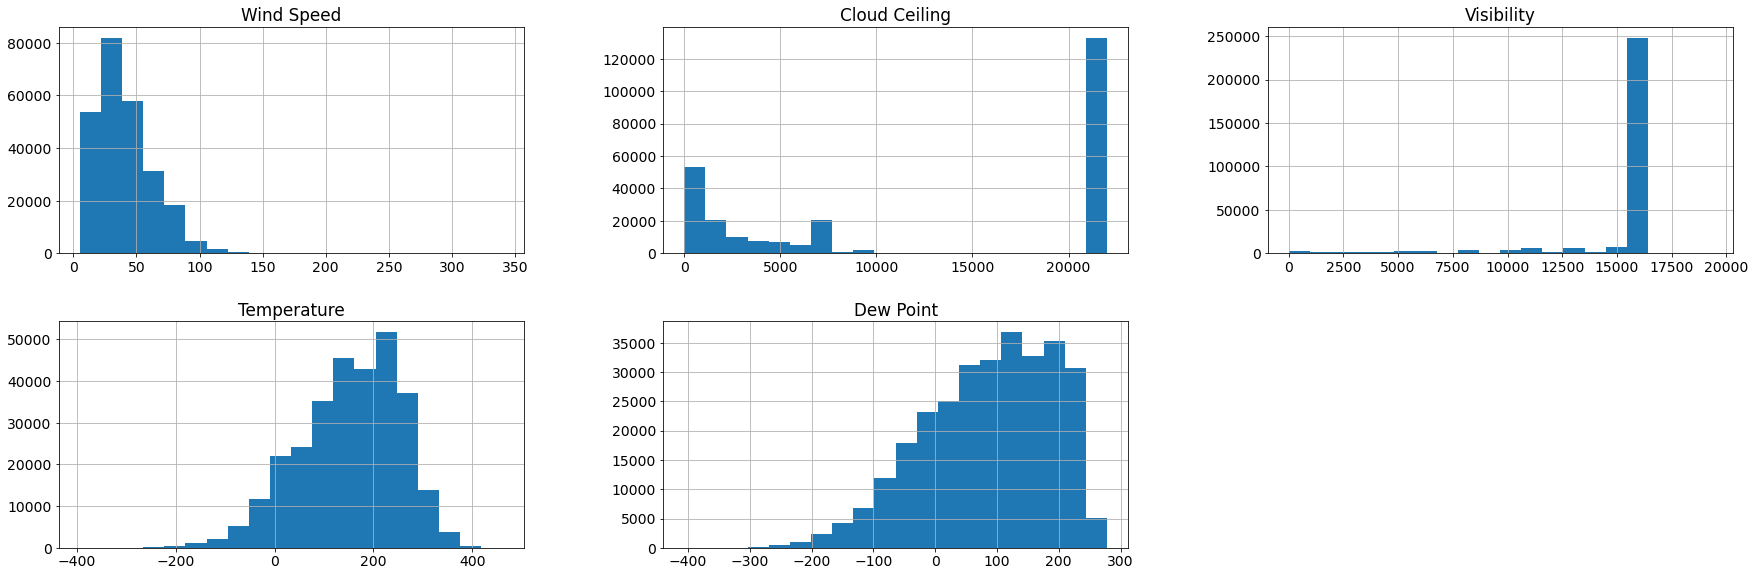

In [0]:
# Reassessing Weather Features After Removing Outliers
FIELDS = [
          'Wind Speed','Cloud Ceiling','Visibility','Temperature'
          ,'Dew Point'
         ]
MASTER_PD[FIELDS].hist(figsize=(30,15), bins=20, layout=(3,3))
plt.show()

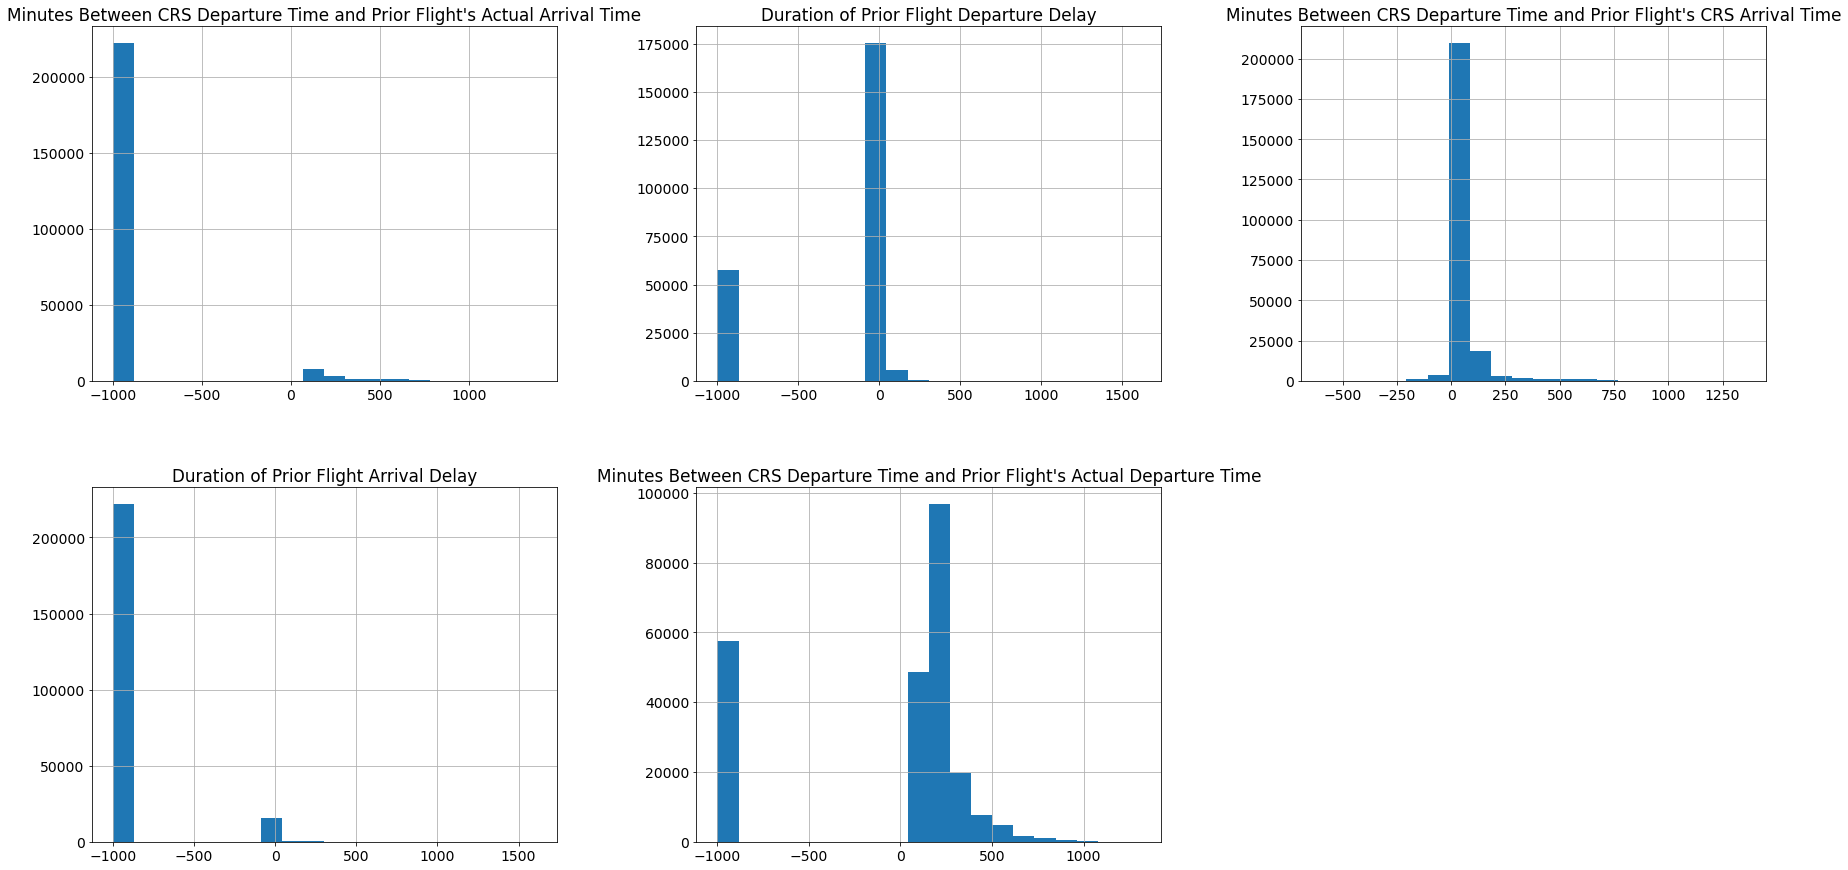

In [0]:
# Distribution of derived features - counts (histogram)
FIELDS = ['Minutes Between CRS Departure Time and Prior Flight\'s Actual Arrival Time'
             ,'Duration of Prior Flight Departure Delay'
  ,'Minutes Between CRS Departure Time and Prior Flight\'s CRS Arrival Time'


  ,'Duration of Prior Flight Arrival Delay' 
            ,'Minutes Between CRS Departure Time and Prior Flight\'s Actual Departure Time']
MASTER_PD[FIELDS].hist(figsize=(30,15), bins=20, layout=(2,3))
plt.show()

In [0]:
tot = full_dataset_sample.count()

full_dataset_sample.groupBy("WEATHER_NOT_NULL") \
  .count() \
  .withColumnRenamed('count', 'COUNTS') \
  .withColumn('PERCENTAGE_OF_TOTAL', (F.col('COUNTS') / tot) * 100 ) \
  .show()

+----------------+------+-------------------+
WEATHER_NOT_NULL|COUNTS|PERCENTAGE_OF_TOTAL|
+----------------+------+-------------------+
 true|312899| 98.76768843729384|
 false| 3904| 1.2323115627061612|
+----------------+------+-------------------+

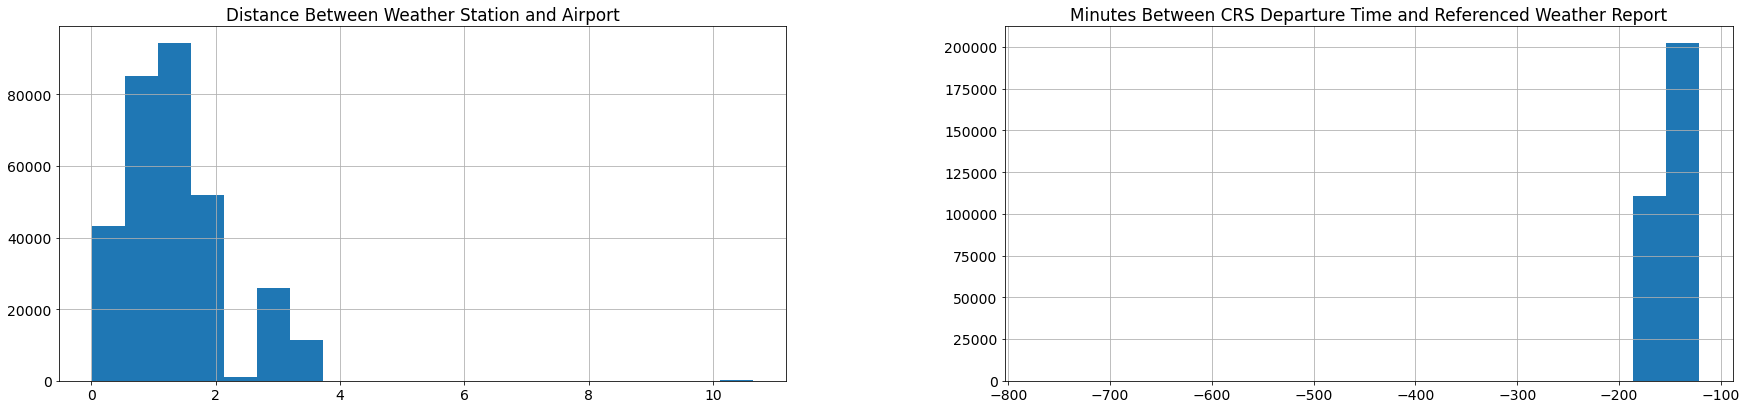

In [0]:
# Distribution of derived features - counts (histogram)
FIELDS = [
  'Distance Between Weather Station and Airport'
  ,'Minutes Between CRS Departure Time and Referenced Weather Report'
         ]
MASTER_PD[FIELDS].hist(figsize=(30,15), bins=20, layout=(2,2))
plt.show()

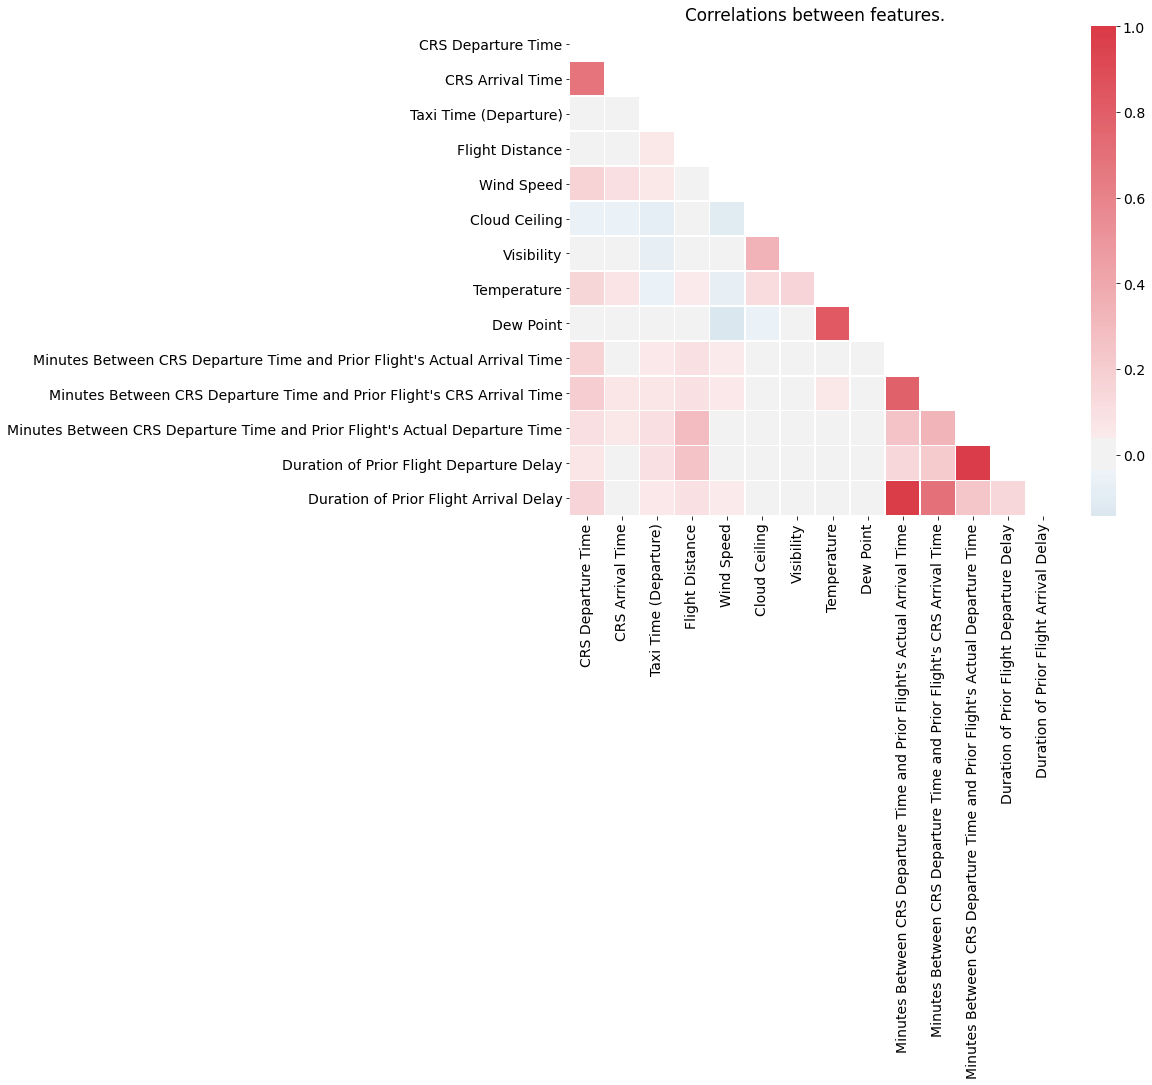

In [0]:
# Correlation matrix (heatmap)

FIELDS = [
  'CRS Departure Time'
  ,'CRS Arrival Time'
  ,'Taxi Time (Departure)'
  ,'Flight Distance'
  ,'Wind Speed'
  ,'Cloud Ceiling'
  ,'Visibility'
  ,'Temperature'
  ,'Dew Point'
  ,'Minutes Between CRS Departure Time and Prior Flight\'s Actual Arrival Time'
  ,'Minutes Between CRS Departure Time and Prior Flight\'s CRS Arrival Time'
  ,'Minutes Between CRS Departure Time and Prior Flight\'s Actual Departure Time'
  ,'Duration of Prior Flight Departure Delay'
  ,'Duration of Prior Flight Arrival Delay'
         ]

corr = MASTER_PD[FIELDS].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

###### Final Dataset Preparation

In [0]:
# Removing outliers in weather data based on assessment of outlier removal effectivness in sample of data used in above EDA section
MASTER = MASTER.withColumn("TEMPERATURE", 
                                       when(col('TEMPERATURE') > 2000, None).otherwise(col('TEMPERATURE')))
MASTER = MASTER.withColumn("DEW_POINT", 
                                       when(col('DEW_POINT') >2000, None).otherwise(col('DEW_POINT')))
MASTER = MASTER.withColumn("VISIBILITY", 
                                       when(col('VISIBILITY') > 20000, None).otherwise(col('VISIBILITY')))
MASTER = MASTER.withColumn("WIND_SPEED", 
                                       when(col('WIND_SPEED') > 500, None).otherwise(col('WIND_SPEED')))

In [0]:
# Encoding categorical columns into numeric
data = MASTER.select('DEP_DEL15', 'MONTH', 'OP_CARRIER', 
                       'ORIGIN', 'TAXI_OUT', 'DISTANCE', 'DEST', 'DAY_OF_WEEK', 
                       'TOTAL_MINUTES', 'TOTAL_MINUTES_ARRIVAL_CRS', 
                       'WIND_SPEED', 'CLOUD_CEILING', 'VISIBILITY', 'TEMPERATURE', 'DEW_POINT'
                       ,'PLANE_FLIGHT_SEQUENCE'
                       ,'PRIOR_FLIGHT_ORIGIN'
                       ,'TIME_DIFF_BT_CRS_DEP_AND_PRIOR_ARR'
                       ,'TIME_DIFF_BT_CRS_DEP_AND_PRIOR_DEP'
                       ,'PRIOR_FLIGHT_DEP_DELAY_AMT'
                       ,'PRIOR_FLIGHT_ARR_DELAY_AMT'
                      )

In [0]:
# Checkpoint
# dbutils.fs.rm(FILE_PATH + "master_pre_cleaned.parquet", recurse=True)
# data.write.parquet(FILE_PATH + "master_pre_cleaned.parquet")

# # Reading in from parquet file
# data = spark.read.parquet(FILE_PATH + "master_pre_cleaned.parquet")

In [0]:
# Derived columns 
cols_mean = ['WIND_SPEED', 'CLOUD_CEILING', 'VISIBILITY', 'TEMPERATURE', 'DEW_POINT', 'TAXI_OUT', 'DISTANCE', 'TOTAL_MINUTES', 'TOTAL_MINUTES_ARRIVAL_CRS',
            'PLANE_FLIGHT_SEQUENCE']

cols_na = ['PRIOR_FLIGHT_ORIGIN', 'MONTH', 'DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST']

cols_neg = ['TIME_DIFF_BT_CRS_DEP_AND_PRIOR_ARR'
           ,'TIME_DIFF_BT_CRS_DEP_AND_PRIOR_DEP'
           ,'PRIOR_FLIGHT_DEP_DELAY_AMT'
           ,'PRIOR_FLIGHT_ARR_DELAY_AMT']


# Imputing missing values with mean in instances where data is legitimately missing
for c in cols_mean:
  c_mean = data.agg({c: 'mean'}).collect()[0][0]
  data = data.na.fill({c: c_mean})
  
# Imputing missing values for specific records where value is intentionally left blank (indicative values vs. missing values) 
for c in cols_na:
  data = data.na.fill({c: 'N/A'})  
  
for c in cols_neg:
  data = data.na.fill({c: -500})  
  
# Dropping any remaining columns with a null (should only be the dependent variable)  
data = data.na.drop(how='any')

In [0]:
# Checkpoint 
# # Saving parquet file
# dbutils.fs.rm(FILE_PATH + "master_cleaned.parquet", recurse=True)
# data.write.parquet(FILE_PATH + "master_cleaned.parquet")

# # Reading in from parquet file
# data = spark.read.parquet(FILE_PATH + "master_cleaned.parquet")

In [0]:
# Verifying no nulls in dataset
missing_values_df = count_missings(data)

missing_values_ddf = pd.DataFrame({
    "features": list(missing_values_df.columns),
    "number_of_nulls": list(missing_values_df.iloc[0])})

missing_values_ddf

Out[77]:

features 
 number_of_nulls 
 
 
 
 
 0 
 DEP_DEL15 
 0 
 
 
 1 
 MONTH 
 0 
 
 
 2 
 OP_CARRIER 
 0 
 
 
 3 
 ORIGIN 
 0 
 
 
 4 
 TAXI_OUT 
 0 
 
 
 5 
 DISTANCE 
 0 
 
 
 6 
 DEST 
 0 
 
 
 7 
 DAY_OF_WEEK 
 0 
 
 
 8 
 TOTAL_MINUTES 
 0 
 
 
 9 
 TOTAL_MINUTES_ARRIVAL_CRS 
 0 
 
 
 10 
 WIND_SPEED 
 0 
 
 
 11 
 CLOUD_CEILING 
 0 
 
 
 12 
 VISIBILITY 
 0 
 
 
 13 
 TEMPERATURE 
 0 
 
 
 14 
 DEW_POINT 
 0 
 
 
 15 
 PLANE_FLIGHT_SEQUENCE 
 0 
 
 
 16 
 PRIOR_FLIGHT_ORIGIN 
 0 
 
 
 17 
 TIME_DIFF_BT_CRS_DEP_AND_PRIOR_ARR 
 0 
 
 
 18 
 TIME_DIFF_BT_CRS_DEP_AND_PRIOR_DEP 
 0 
 
 
 19 
 PRIOR_FLIGHT_DEP_DELAY_AMT 
 0 
 
 
 20 
 PRIOR_FLIGHT_ARR_DELAY_AMT 
 0

In [0]:
# One hot encoding - categorical columns into binary sparse vectors

# Define categorical columns 
categoricalColumns = ['PRIOR_FLIGHT_ORIGIN', 'MONTH', 'DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST']
stages = [] # stages in Pipeline

for categoricalCol in categoricalColumns:
  
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    if LooseVersion(pyspark.__version__) < LooseVersion("3.0"):
        from pyspark.ml.feature import OneHotEncoderEstimator
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    else:
        from pyspark.ml.feature import OneHotEncoder
        encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
        
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [0]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="DEP_DEL15", outputCol="label")
stages += [label_stringIdx]

In [0]:
# Transform all features into a vector using VectorAssembler
numericCols = ['WIND_SPEED', 'CLOUD_CEILING', 'VISIBILITY', 'TEMPERATURE', 'DEW_POINT', 'TAXI_OUT', 'DISTANCE', 'TOTAL_MINUTES', 'TOTAL_MINUTES_ARRIVAL_CRS',
            'PLANE_FLIGHT_SEQUENCE', 'TIME_DIFF_BT_CRS_DEP_AND_PRIOR_ARR'
           ,'TIME_DIFF_BT_CRS_DEP_AND_PRIOR_DEP'
           ,'PRIOR_FLIGHT_DEP_DELAY_AMT'
           ,'PRIOR_FLIGHT_ARR_DELAY_AMT']


assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [0]:
# Prepare pipeline data 

# Develop df_flights_prepped 
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(data)
model_data = pipelineModel.transform(data)
# display(model_data)

In [0]:
# Keep relevant columns
selectedcols = ["label", "features"]
model_data = model_data.select(selectedcols)
# display(model_data)

In [0]:
# Split data into train and test sets
(assembled_data, testData) = model_data.randomSplit([0.8, 0.2])

In [0]:
# Handle imbalanced data by obtaining class weights and adding as a column in training dataset

# Obtain class weights
y_collect = assembled_data.select("label").groupBy("label").count().collect()
unique_y = [x["label"] for x in y_collect]
total_y = sum([x["count"] for x in y_collect])
unique_y_count = len(y_collect)
bin_count = [x["count"] for x in y_collect]

# Putting Class Weights into dataframe as a column
class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
print(class_weights_spark) 

{0.0: 0.6112806912869027, 1.0: 2.746571234496134}

In [0]:
# Putting Class Weights into DF as a column
mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])

assembled_data = assembled_data.withColumn("weight", mapping_expr.getItem(F.col('label')))

In [0]:
# Checkpoint 
# # Saving parquet file
# dbutils.fs.rm(FILE_PATH + "assembled_data.parquet", recurse=True)
# assembled_data.write.parquet(FILE_PATH + "assembled_data.parquet")

# dbutils.fs.rm(FILE_PATH + "testData.parquet", recurse=True)
# testData.write.parquet(FILE_PATH + "testData.parquet")

# # Reading in from parquet file
# assembled_data = spark.read.parquet(FILE_PATH + "assembled_data.parquet")
# testData = spark.read.parquet(FILE_PATH + "testData.parquet")

In [0]:
# Final Record Count
assembled_data.count()

Out[7]: 25012453

#### Section 5 - Cross-Validation

One last step prior to training and evaluating models on the full dataset was to use cross-validation in order to obtain a sense for the best hyperparamters to use when training the models on our full training dataset.  Due to the computationally-intensive nature of cross-validation, this process is performed only using a small sample of the training data, uses only 3-folds, and is only performed for the Gradient Boosted Tree model.

In [0]:
# Sample of assembled_data
assembled_data_small = assembled_data.sample(.0025)

In [0]:
assembled_data_small.count()

Out[90]: 62352

In [0]:
gb = GBTClassifier(labelCol="label", featuresCol="features", weightCol="weight")

In [0]:
gbparamGrid = (ParamGridBuilder()
             .addGrid(gb.maxDepth, [2, 5, 10])
             .addGrid(gb.maxBins, [10, 1000, 5000])
             .addGrid(gb.maxIter, [10, 15, 20])
             .build())

In [0]:
gbevaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC')


In [0]:
# Create 3-fold CrossValidator
gbcv = CrossValidator(estimator = gb,
                      estimatorParamMaps = gbparamGrid,
                      evaluator = gbevaluator,
                      numFolds = 3)

In [0]:
gbcvModel = gbcv.fit(assembled_data_small)
print(gbcvModel)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
CrossValidatorModel_47b67e36b10d

#### Section 6 & 7 & 8 - Algorithm Theory, Algorithm Implementation and Conclusion

Three classification algorithms were selected for this analysis: logistic regression, random forest, and gradient boosted tree. The gradient boosted tree is the model which we assessed to be the best performing. For this reason, we consider the gradient boosted tree model to be our primary model and is the one which we focused on optimizing using cross-validation (shown above).  

***Theory***

Logistic regresion is a binary classification algorithm (flight is > 15 delayed or not). As with linear regression, logisitic regression also tries to identify how a response variable changes as the explanatory variables change. Logistic regression however deals with the case when the response variable is binary. The regression relies on a probability curve (e.g. given these features, the likelihood the flight is delayed > 15 minutes) to determine if the regression analysis classifies the output as 1 (delayed > 15) or 0 (not). The shape of the probability curve and the threshold for classification therefore have a material impact on this models performance. As previously discussed, changes to the classification threshold were out of scope for this analysis, but should be considered in future research.

Random forest is an information based learning algorithm which attempts to classify the target variable based on the features in the fewest possible branches. This is done creating many decision trees, based on computing information entropy (maximize information gain - how helpful is knowing this information in determing the correct class?) for each response variable. The top variable is the variable which can with one single piece of information resolve as many options for the target variable as possible. In some datasets, these decision trees become biased to focus on misclassified examples; however, this can be resolved through boosting. Some algorithms become too specific to the training data (overfit) to be generalizable to new data. This is resolved with bagging (aka bootstrap aggregating) or subspace sampling. The Random Forest algorithm is a decision tree which also leverages the mathematical techniques of boosting, bagging and subspace sampling to avoid inappropriate focus or overfitting. 

Gradient boosted tree, like random forest is a set of decision trees. Unlike random forests, which built each tree independently, the gradient boosted tree algorithm builds each tree one at a time, and uses them in a sequential manner. In addition, gradient boosted tree combines results along the way whereas random forest averages results at the end. 

While random forest may sound better than logistic regression, and gradient boosted tree even better than random forest, algorithm performances is often data dependent. For this reason, we will compare all three. 

The mathematical definitions for each algorithm are widely available on the internet but excluded here for brevity. Key mathematical concepts include: 
- Logistic regreession: linear regression + probability function
- Decision tree: information gain / entropy analysis
- Random forest and gradient boosted tree: boosting, bagging and subspace sampling

***Toy Example***

*Set-up - asssume the following limited columns and records from the final dataset:*
- DEP_DEL15 = 1, 0, 1, 0
- MONTH = 1, 2, 1, 3 --> will be converted to numeric, and spread across twelve columns (JAN - DEC) through one hot encoding
- ORIGIN = EWR, JAN, EQR, ORD --> will be converted to numeric, and spread across three columns (EWR, JAQ, AQR) through one hot encoding
- WIND_SPEED = 88, 15, 62, 36
- DEW_POINT = -133, -6, -156, -139
- Note: additional transformations are being skipped for explainabiltiy purposes (scaling, vectorization, centering)

*Logistic Regression*
- A model will be trained on the training dataset to find an ordinary least squares regression line of y (DEP_DEL15) and X (MONTH, ORIGIN, WIND_SPEED, DEW_POINT) that makes the sum of the squares of the vertical distances of the data points from the line as small as possible. Finding the combination of weights can be done through either a closed form solution, or in the case of our algorithm through gradient descent. Gradient descent will gradually change the slope and intercept until we reach the optimum solution. 
- Example optimal regression solution y = .03(MONTH) + .021(ORIGIN) + .001(WIND_SPEED) + 0.0003(DEW_POINT) + .01 --> for Record 2 this would yield ~ 0.1
- The output is then compared to a probability curve indicating likelihood of the outcome (sigmoid or other) and threshold (in this case 15 minutes) to determine if the result 0.1 is more likely to be delayed 15 minutes or not [DEP_DEL15 = 1 or 0]
- In the case of 0.1, DEP_DEL15 prediction would be set to 0

*Decision Tree*
- Decision Tree - a model will be trained on the training dataset to create a tree that can determine in the fewest steps possible the proper classification of y DEP_DEL15 based on the X (feature) variables. For each feature and value the algorithm will compute the probabilities of the given variable occuring, for ORIGIN P(EWR) = 2/4 = 0.50. This will be used to compute the entropy (heterogeneity) of the entire data table - entropy for one feature would be = sum ((probability of value1 * log(probability of value1) + (probability of value 2 * log(probability of value2). etc...). 
- Example entropy of month --> 0.5 (LOG(0.5)) + -0.25 (LOG(0.25)) + -0.25 (LOG(0.25)) = 1.5
- For each predictor variable (MONTH, ORIGIN, WIND_SPEED) the table will be split by that predictor variable, the algorithm will compute the impurity (entropy) for the pair constituting of each predictor variable and the response variable
- The information gain will be computed as --> entropy of the parent table - sum(nk/n * entropy of the subset table)
- The predictor variable which provides the maximum information gain is selected as the next node of the tree, in the above example MONTH = 1 has the highest information gain (provides the most information about the likelihood of DEP_DEL15 = 1), so MONTH would be the first node of the decision tree 
- The dataset is then reduced by the used features (and deterministic records), then the algorithm is repeated recursively with the remaining table 

The difficulty with Decision Trees is they can often have low accruacy, high variance and can be overfit - they are also considered weak learners. The solution is ensemble learning, our analysis will consider both Random Forest and Gradient Boosted Tree. Random Forest is used to reduce variance by combining results from many trees and Gradient Boosted Tree is used to turn many decision trees (weak learners with low correlation to the true classification) into a single strong learner that is well correlated with the 'true' classification.  

*Random Forest*
- Random forests start with the base decisiion tree methodolgy
- The algorithm completes one decision tree cycle, then selects a random sample of records with replacement (bootstrapping)
- The algorithm trains the learning models seperately for random samples 
- In the case of our toy dataset, if record #1 [1, 1, EWR, 88, -133] was sampled 3 times and record #3 [1, 1, EQR, 62, -156] was sampled 1 time MONTH would again be the first node, yet ORIGIN, WIND_SPEED and DEW_POINT would be tied selected as the second level node
- The final prediction is the mean (regression tree) and maximum vote (when doing classification - as in this case) of the decision trees

*Gradient Boosted Tree*
- Gradient boosted tree starts with the base decision tree methodology, but adds the concept of boosting by computing a loss function for each decision tree and focusing on improving the loss function for the next sequential tree
- After each full cycle of decision tree build, the sampled dataset is weighted - misclassified data increases it weights to emphasize the most difficult cases
- When the next decision tree is built the weighted data is used, therefore subsequent learners will focus more on mis-classified data during training
- The art of gradient boosted tree is most clear on larger data samples - but for conceptual purposes - in our toy example case, the entire dataset would receive an additional two columns (weight, running score) 
- Each time the decision tree was completed, the weights and running score would be adjusted
- The updated weights would be used to determine the newly sampled dataset
- Example for conceptual purposes: In our initial dataset, record 2 represents 1/4 of the set. If record 2 was frequently mis-classified [0, 2, JAN, 15, -6], over time, it would represent more of the dataset (example 50%) so the more difficult record is selected more often for training
- To make gradient boosted tree paralleizable, the models themselves are assigned weights in order to take a weighted average of their estimates during prediction


***Implementation***

In the implementation of the algorithms, parameter definition proved to have a significant impact on the area under the ROC curve. Due to limited processing capacity (shared cluster, which was especially time consuming for higher maxDepth values) we took a limited approach to cross validation. This process is described briefly in the previous section; however, based on the results of this process, we opted for maxIter = 20, maxDepth = 5, and maxBins = 1000, which is the combination of hyperparameters that achieved the highest area under the ROC curve during the cross-validation process. The full results of the cross-validation process are not included in this notebook but can be made available on request.

Additionally, we evaluated a couple of options in order to address the class imbalance during training.  The first option was to downsample the majority class (i.e. not delayed) in order to obtain a balanced training dataset. The second option was to obtain the ratio between the two classes and input those class weights into the model, so the model could be trained to account for the imbalance.  We elected to choose the latter option, as it does not discard data.  In any event, the model was evaluated using a test dataset which maintained the class imbalance that exits in the full dataset.

***Feature Importances***

While prediction is the main focus of this project, the ability to develop some understanding of which independent variables are important in terms of prediction, as well as the degree to which they are important is useful information. Though the ability to obtain feature importances does not appear to be available in all model types in Spark, it is available using the Random Forest classifier, which is one of the models we implemented. As can seen below, the most important feature was Total Minutes, which is an indication of when the flight was scheduled to depart (i.e. CRS Departure Time). This is not entirely surprising given the relationship we observed in earlier EDA (Section 2) between the proprotion of flights that are delayed and the flight's departure time. Following this feature (in terms of importance) is the plane's prior flight's origin of departure. Here, we can see that the "N/A" entry is especially impactful, indicating that whether or not it is the plane's first flight of the day is predictive of whether or not it will be delayed. This also seems reasonable given that a plane's first flight of the day cannot be impacted by earlier flights which may have been delayed. We can see that the scheduled arrival time (i.e. CRS Arrival Time) is the next most impactful feature; however, this is not entirely unexpected given that these two features are fairly correlated as shown in the correlation matrix shown in earlier EDA (Section 4). We can then see that the next two most important features are the plane's prior flight's departure delay and the amount of time between that departure and the current flight's scheduled departure time.  Lastly, we can see that several of the next most important features are weather-related; however, none of these features have a relative importance of >5%.

***Conclusion***

While the business use case should determine which metric is most important as discussed above, this analysis chose to place the highest importance on the area under the ROC curve. Below are the results we achieved in terms of this metric for the 3 models we trained and evaluated.
- Gradient boosted tree: 0.77
- Random forest classifier: 0.69
- Logistic regression: 0.73

With the previously noted limitations (limited compute resources, data limitations, algorithm limmitations, and design limitations), this limited exercise shows gradient boosted tree was, in fact, the best algorithm at predicting whether or not a flight delay will be greater than 15 minutes. Moreover, the gradient boosted tree also achieved the highest area under the precision-recall curve and F1 score, two other important measures of model performance. Digging into the results of the gradient boosted tree model a bit more, we can also see that the model is achieving a positive predictive value of ~36%, indicating that of our positive (i.e. delayed) predictions, ~36% of them will be true positives and ~64% will be false positives. If this model were to be used to communicate potential delays to customers, it would likely also be prudent to include this metric, as opposed to overall accuracy, as from the customer's perspective, all that matters is how likely it is that the delayed prediction will be correct.  If the model ends up being more intended for airlines operation management, it might be more important to focus on the sensitivity of the positive (i.e. delayed) predictions.  Here we case see that the gradient boosted tree model is achieving a sensitivity of 62% for delayed predictions, meaning that of all of the delays that occur, our model is predicting 62% of them and misclassifying 38% of them. As with the customer use case, for this use case, operations management sould also be provided with this metric, perhaps as well as the positive predictive value, in order to provide some insight into how many of the delays the model will help them address. Additionally, having some degree of insight into which features are most useful in predicting delays may also be useful from an operations management perspective. For example, we have seen (both in EDA and in the feature importance table) that flights later in the day tend to be more susceptible to delays. Consequently, operations management may want to focus more efforts on optimizing flight management such that additional effort is given to address flight delays earlier on before they can compound over the course of the day and become more severe and difficult to correct.

Further model evaluation metrics are available below, including confusion matrices (true positive, true negative, false positive, false negative) and accuracy.  Additionally, further analysis should be done focused on changing classification thresholds, assessing the impact of adding additional weather and flight data, and further cross-validation (or grid search) to optimize parameters, especially for the models for which cross-validation was not used. That said, compared to the baseline area under the ROC values of .71 and .90 (Ref 1), the value we achieved (.77) seems reasonable.

###### Algorithm 1 - Gradient Boosted Tree

In [0]:
# Define a gradient boosted tree model
gbt = GBTClassifier(featuresCol="features",
                    labelCol="label",
                    weightCol="weight",
                    lossType = "logistic",
                    maxIter = 20,
                    maxDepth = 5,
                    maxBins = 1000
                   )

# Chain indexer and GBT in a Pipeline
stages_gbt = [gbt]

pipeline_gbt = Pipeline(stages=stages_gbt)

# Train the tuned model and establish our best model
gbt_model = pipeline_gbt.fit(assembled_data)


In [0]:
# Make predictions
predictions = gbt_model.transform(testData)

In [0]:
# Model Evaluation
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC')
evaluator.evaluate(predictions)

# Model Evaluation with scikit learn
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

# Print metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

precision recall f1-score support

 0.0 0.90 0.75 0.82 5116655
 1.0 0.36 0.62 0.46 1140080

 accuracy 0.73 6256735
 macro avg 0.63 0.69 0.64 6256735
weighted avg 0.80 0.73 0.75 6256735

[[3857079 1259576]
 [ 431335 708745]]

In [0]:
# Model evaluation with helper function
print_results(predictions)

Test Area Under ROC: 0.77
Test Area Under Precision-Recall Curve: 0.49
True positive rate: 64.84%
True negative rate: 75.98%
False positive rate: 24.02%
False negative rate: 35.16%
Recall: 64.84%
########### Confusion Matrix ###########
 Prediction: delay Prediction: on-time
Actual: delay 739229 400851
Actual: on-time 1229092 3887563

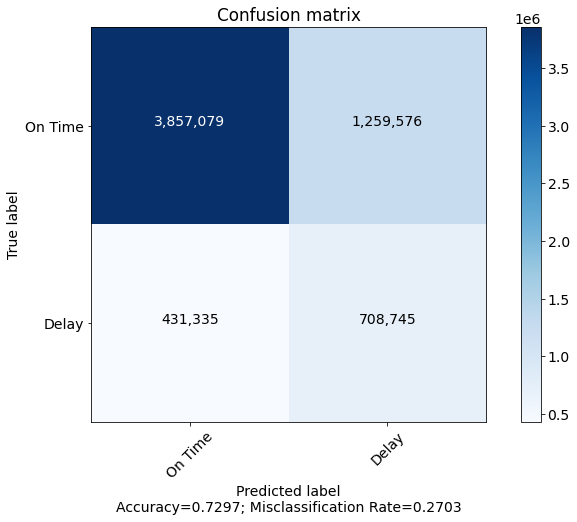

In [0]:
# Plot confusion matrix
plot_confusion_matrix(confusion_matrix(y_true, y_pred), ['On Time', 'Delay'], normalize=False)

###### Algorithm 2 - Random Forest Classifier

In [0]:
# Fit random forest classifier 
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol="features",
                              labelCol="label",
                              weightCol="weight",)
model = rf.fit(assembled_data)


# Generate Predictions
predictions = model.transform(testData)

In [0]:
# Model Evaluation
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC')
evaluator.evaluate(predictions)

# Model Evaluation with scikit learn
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

# Print metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

precision recall f1-score support

 0.0 0.90 0.46 0.61 5116655
 1.0 0.24 0.76 0.37 1140080

 accuracy 0.52 6256735
 macro avg 0.57 0.61 0.49 6256735
weighted avg 0.78 0.52 0.57 6256735

[[2375184 2741471]
 [ 270713 869367]]

In [0]:
# Model evaluation with helper function
print_results(predictions)

Test Area Under ROC: 0.69
Test Area Under Precision-Recall Curve: 0.36
True positive rate: 76.25%
True negative rate: 46.42%
False positive rate: 53.58%
False negative rate: 23.75%
Recall: 76.25%
########### Confusion Matrix ###########
 Prediction: delay Prediction: on-time
Actual: delay 869367 270713
Actual: on-time 2741471 2375184

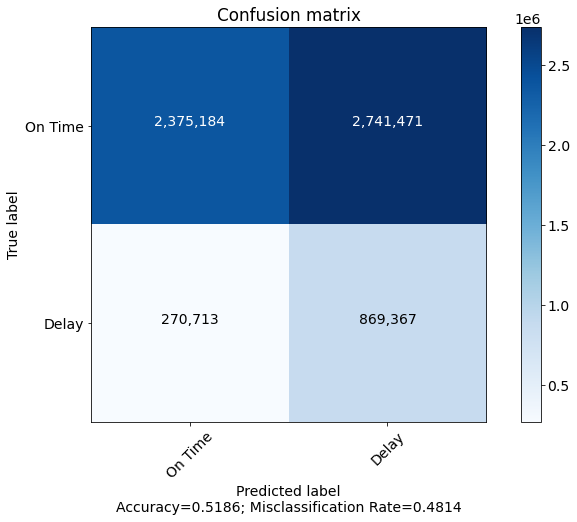

In [0]:
# Plot confusion matrix
plot_confusion_matrix(confusion_matrix(y_true, y_pred), ['On Time', 'Delay'], normalize=False)

In [0]:
# Feature Importances
dataset_fi = ExtractFeatureImportance(model.featureImportances, assembled_data, "features")
dataset_fi = sqlContext.createDataFrame(dataset_fi)
display(dataset_fi)

idx name score 1148 TOTAL_MINUTES 0.19247676823794646 0 PRIOR_FLIGHT_ORIGINclassVec_N/A 0.10489140536002092 1149 TOTAL_MINUTES_ARRIVAL_CRS 0.09943173823441914 1153 PRIOR_FLIGHT_DEP_DELAY_AMT 0.06769500344388782 1152 TIME_DIFF_BT_CRS_DEP_AND_PRIOR_DEP 0.05113300460829429 1143 VISIBILITY 0.03927344304780542 17 PRIOR_FLIGHT_ORIGINclassVec_EWR 0.036039310606120784 1141 WIND_SPEED 0.03343258385458602 1144 TEMPERATURE 0.03200930374621906 376 MONTHclassVec_11 0.03185801362922123 377 MONTHclassVec_9 0.02519853878403304 1150 PLANE_FLIGHT_SEQUENCE 0.024662034882110606 386 OP_CARRIERclassVec_DL 0.024471475391014685 372 MONTHclassVec_10 0.02332911104167095 1154 PRIOR_FLIGHT_ARR_DELAY_AMT 0.022732840024153215 1145 DEW_POINT 0.019724918477853116 419 ORIGINclassVec_EWR 0.012427733319761625 385 OP_CARRIERclassVec_WN 0.011109180568846501 1142 CLOUD_CEILING 0.01071640063208845 773 DESTclassVec_ATL 0.009812697385558821 391 OP_CARRIERclassVec_B6 0.009590313416422427 27 PRIOR_FLIGHT_ORIGINclassVec_DAL 0.009526137205851487 45 PRIOR_FLIGHT_ORIGINclassVec_HNL 0.008779793095316511 1151 TIME_DIFF_BT_CRS_DEP_AND_PRIOR_ARR 0.008693317430282965 778 DESTclassVec_SFO 0.008584791770390943 404 ORIGINclassVec_ORD 0.008454014671303597 1146 TAXI_OUT 0.00708089060648841 809 DESTclassVec_HNL 0.0049228440566671 408 ORIGINclassVec_SFO 0.0047689668349583155 370 MONTHclassVec_6 0.004387055772853179 850 DESTclassVec_LIH 0.004104795447401471 430 ORIGINclassVec_DAL 0.003569321853426737 21 PRIOR_FLIGHT_ORIGINclassVec_BWI 0.003437265844338416 13 PRIOR_FLIGHT_ORIGINclassVec_MCO 0.003420414559871093 94 PRIOR_FLIGHT_ORIGINclassVec_KOA 0.003036472523257907 789 DESTclassVec_EWR 0.0029020132770795726 392 OP_CARRIERclassVec_AS 0.0023990407532445772 33 PRIOR_FLIGHT_ORIGINclassVec_HOU 0.0023930987495999335 780 DESTclassVec_CLT 0.0023903089652573648 4 PRIOR_FLIGHT_ORIGINclassVec_DEN 0.0023399118573161266 400 OP_CARRIERclassVec_HA 0.0022286562337386798 31 PRIOR_FLIGHT_ORIGINclassVec_STL 0.0016826819183491531 405 ORIGINclassVec_DFW 0.0016014238315139033 434 ORIGINclassVec_HOU 0.0014738505064792328 439 ORIGINclassVec_HNL 0.0013899801806812728 7 PRIOR_FLIGHT_ORIGINclassVec_SFO 0.0012098047072737427 397 OP_CARRIERclassVec_F9 0.0010266339280302495 420 ORIGINclassVec_SLC 9.725676534406619E-4 788 DESTclassVec_LGA 9.415648479202246E-4 388 OP_CARRIERclassVec_OO 9.375495901767788E-4 556 ORIGINclassVec_GJT 8.851048201858353E-4 18 PRIOR_FLIGHT_ORIGINclassVec_SLC 7.677726686323616E-4 389 OP_CARRIERclassVec_UA 6.91349039540014E-4 426 ORIGINclassVec_MDW 5.738420768849506E-4 5 PRIOR_FLIGHT_ORIGINclassVec_LAX 5.50376282713859E-4 368 MONTHclassVec_7 4.8732915673491974E-4 879 DESTclassVec_ITO 4.8552140774029285E-4 791 DESTclassVec_JFK 4.809547644865194E-4 3 PRIOR_FLIGHT_ORIGINclassVec_DFW 3.947299932688956E-4 406 ORIGINclassVec_DEN 3.171944506669651E-4 75 PRIOR_FLIGHT_ORIGINclassVec_OGG 3.0094296183706004E-4 373 MONTHclassVec_3 2.684823485249445E-4 1147 DISTANCE 2.632873203547191E-4 20 PRIOR_FLIGHT_ORIGINclassVec_JFK 2.473343027657518E-4 9 PRIOR_FLIGHT_ORIGINclassVec_LAS 2.049619831112959E-4 2 PRIOR_FLIGHT_ORIGINclassVec_ORD 1.8371274941859193E-4 415 ORIGINclassVec_SEA 1.8168728015277585E-4 381 DAY_OF_WEEKclassVec_4 1.7064548746068155E-4 445 ORIGINclassVec_CLE 1.6450093214907783E-4 10 PRIOR_FLIGHT_ORIGINclassVec_BOS 1.3756605948078989E-4 23 PRIOR_FLIGHT_ORIGINclassVec_PHL 1.0704981047644686E-4 901 DESTclassVec_JNU 1.0217971149974471E-4 527 ORIGINclassVec_ASE 1.0087992361998241E-4 459 ORIGINclassVec_ABQ 9.849075744182099E-5 414 ORIGINclassVec_DTW 8.113960854448741E-5 379 DAY_OF_WEEKclassVec_5 7.643383126168185E-5 503 ORIGINclassVec_MHT 6.473628404011429E-5 786 DESTclassVec_MCO 6.0495931786425764E-5 387 OP_CARRIERclassVec_AA 6.045336975350104E-5 32 PRIOR_FLIGHT_ORIGINclassVec_AUS 5.797533823651963E-5 603 ORIGINclassVec_BQN 5.611970870762017E-5 8 PRIOR_FLIGHT_ORIGINclassVec_CLT 5.0461356511187905E-5 410 ORIGINclassVec_CLT 4.626994764153259E-5 412 ORIGINclassVec_LAS 4.455572461935439E-5 413 ORIGINclassVec_

###### Algorithm 3 - Logistic Regression

In [0]:
# Create initial LogisticRegression model
lr = LogisticRegression(featuresCol="features",
                              labelCol="label",
                              weightCol="weight",)
 
# Train model with Training Data
lrModel = lr.fit(assembled_data)

In [0]:
# Generate predictions
predictions = lrModel.transform(testData)

In [0]:
# Model Evaluation
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC')
evaluator.evaluate(predictions)

# Model Evaluation with scikit learn
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

# Print metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

precision recall f1-score support

 0.0 0.90 0.70 0.78 5116655
 1.0 0.32 0.65 0.43 1140080

 accuracy 0.69 6256735
 macro avg 0.61 0.67 0.61 6256735
weighted avg 0.79 0.69 0.72 6256735

[[3557739 1558916]
 [ 397073 743007]]

In [0]:
# Model evaluation with helper function
print_results(predictions)

Test Area Under ROC: 0.73
Test Area Under Precision-Recall Curve: 0.41
True positive rate: 65.17%
True negative rate: 69.53%
False positive rate: 30.47%
False negative rate: 34.83%
Recall: 65.17%
########### Confusion Matrix ###########
 Prediction: delay Prediction: on-time
Actual: delay 743007 397073
Actual: on-time 1558916 3557739

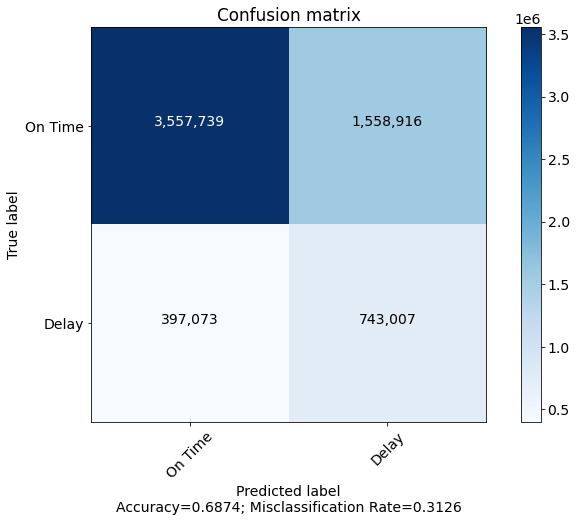

In [0]:
# Plot confusion matrix
plot_confusion_matrix(confusion_matrix(y_true, y_pred), ['On Time', 'Delay'], normalize=False)

#### Section 9 - Application of Course Concepts

Key course concepts applied in this exercise, specifically: 

**Caching** – We used caching in the project in order to speed up our ability to access Spark dataframe. Even in instances where there may be insufficient to cache all of the data being assessed, it is advantageous to cache data where possible. Spark will cache whatever it can in memory and spill the rest to disk. There are several benefits of caching a DataFrame: 1.) Reading data from source. 2.) Creating Checkpoints 3.) Even with limited memory, performance will increase from use of local evaluators 4.) Caching fraction of data is still beneficial for performance (Ref 4)

**Lazy evaluation** – It became obvious when working in the Databricks notebook for the project that transformations executed on Spark dataframes were instantaneous, whereas actions required sometimes subtantial time for the computations to occur. Often times we used count() to check our work but needed to comment this out as it would take an excessive amount of time to run. Lazy evaluation means the execution of transformations isn't triggered until there is an action that needs results. RDDs/Dataframes support two types of operations: transformations, which create a new dataset from an existing one, and actions, which return a value to the driver program after running a computation on the dataset. (Ref 5)

**One hot encoding / vector embedding** - One hot encoding and vector embedding were required to complete this analysis. With one hot encoding, we convert categorical columns into binary sparse vectors. This required two main steps: string indexing to encode categorial columns to numeric and one hot encoding to remove ordinal relationships from categories. With one hot encoding, we create additional columns to make binary indicator for each variable which is being encoded. Vector embeddings were completed by collecting features unsing the vector assembler, then applying the scalars to vector data types. Both of these were essential to running the core algorithms. 

**Cross-validation** - Cross-validation first entailed splitting the dataset into a set of folds. Within each fold, we have a separate training and test partition. In our case, we used k=3 folds, meaning that we split our dataset in three different ways (each with a training and test partition).  In each of these splits, the training partition accounted for 2/3 of the data and the test partition consisted of 1/3 of the data. As part of the cross-validation process, we also established a paramter map which contained a range of values for several hyperparameters (e.g. max depth). These hyperparameters were evaluated as part of the process, wherein an average evaluation metric was produced by the 3 models (one for each fold) for each combination of hyperparamters. It was then simply a matter of obtaining the combination of hyperparameters which resulted in the highest average area under the ROC curve. We used the area under the ROC curve as our evaluation metric in the cross-validation process, as this was the same metric we used in training and evaluating our models. Lastly, though it would have been possible to train our model(s) using cross-validation on the full dataset, we elected not to do this due to the computationally intensive nature of this operation and the limited time and resources available. (Ref 6)


REF 4: https://towardsdatascience.com/apache-spark-caching-603154173c48

REF 5: https://spark.apache.org/docs/latest/rdd-programming-guide.html

REF 6: https://spark.apache.org/docs/latest/ml-tuning.html